### 0. Imports

In [25]:
%load_ext autoreload
%autoreload 2

# Data transformation
# ------------------------------------------------------
import pandas as pd
import numpy as np
import math

# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Preprocessing and clustering
# ------------------------------------------------------
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, pairwise_distances,  davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs
import src.soporte_outliers as so

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def plot_3D_clusters(dataframe):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the PCA-transformed data
    ax.scatter(dataframe.iloc[:, 0], dataframe.iloc[:, 1], dataframe.iloc[:, 2], c='b', s=50, alpha=0.6, edgecolor='k')
    
    # Labels and title
    ax.set_title('3D PCA Clusters')
    ax.set_xlabel(f"{dataframe.columns[0]}")
    ax.set_ylabel(f"{dataframe.columns[1]}")
    ax.set_zlabel(f"{dataframe.columns[2]}")

    plt.show()


# function to calculate corr per client
def calculate_discount_expense_correlation(grupo):
    if len(grupo['discount'].unique()) > 1: # if there's variation in discounts
        return grupo['discounted_price'].corr(grupo['sales'], method="spearman")  # return pearson corr
    return 0  # else 0


def choose_kmeans_k(dataframe):
    # Define range of clusters
    k_range = range(2, 16)
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davies_bouldin = []

    X = dataframe

    # Fit KMeans for each k and calculate metrics
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X, kmeans.labels_))
        calinski_harabasz.append(calinski_harabasz_score(X, kmeans.labels_))
        davies_bouldin.append(davies_bouldin_score(X, kmeans.labels_))


    # Plot metrics
    plt.figure(figsize=(15, 10))

    # Inertia Plot
    plt.subplot(2, 2, 1)
    plt.plot(k_range, inertia, marker='o')
    plt.title('Inertia')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')

    # Silhouette Score
    plt.subplot(2, 2, 2)
    plt.plot(k_range[1:], silhouette[1:], marker='o')  # Skip k=1
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')

    # Calinski-Harabasz Index
    plt.subplot(2, 2, 3)
    plt.plot(k_range[1:], calinski_harabasz[1:], marker='o')  # Skip k=1
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')

    # Davies-Bouldin Index
    plt.subplot(2, 2, 4)
    plt.plot(k_range[1:], davies_bouldin[1:], marker='o')  # Skip k=1
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()


def perform_PCA(dataframe):
    pca = PCA()
    X_pca = pd.DataFrame(pca.fit_transform(dataframe))

    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Plot explained variance
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='orange')

    # Add titles and labels
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    return X_pca


def t_sne(dataframe, dim=2, perplexity=5):
    # Perform t-SNE
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, max_iter=1000)
    X_tsne = tsne.fit_transform(dataframe)

    if dim == 2:
        # Plot the t-SNE results in 2D
        plt.figure(figsize=(8, 6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='b', alpha=0.6, edgecolor='k', s=50)
        plt.title(f't-SNE Visualization, perplexity {perplexity}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid()
        plt.show()

    else:
        # Plot the t-SNE results in 3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot of t-SNE results
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c='b', alpha=0.6, edgecolor='k', s=50)

        # Add labels and title
        ax.set_title(f't-SNE Visualization in 3D, perplexity {perplexity}')
        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')
        ax.set_zlabel('t-SNE Dimension 3')

        plt.show()



# 1. Intro to clustering v3 notebook and data import

## 1.1 Introduction

The purporse of this clustering notebook is to re-evaluate features and preprocessing used for clustering.

## 1.2 Data import

In [27]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")

# 2. Clustering - customers

## 2.1 Changes with respect to v1 and v2

- Introduction of categorical features

## 2.2 Aggregation

To cluster by customer, it is necessary for the data to have each row to represent each customer.

##### Calculate median orders month

In [28]:
global_superstore["year_month"] = global_superstore["order_date"].dt.to_period('M')
global_superstore["year_month"]

0        2012-07
1        2013-02
2        2013-10
3        2013-01
4        2013-11
          ...   
51285    2014-06
51286    2014-06
51287    2013-12
51288    2012-02
51289    2012-05
Name: year_month, Length: 51290, dtype: period[M]

In [29]:
median_purchase_freq = global_superstore.groupby(
    ["customer_id", "year_month"]
).agg(
    orders_month=("order_id", "nunique")
).groupby("customer_id").agg(median_orders_month=("orders_month","median"))

median_purchase_freq.head()

median_orders_month
customer_id                     
AA-10315                     1.0
AA-10375                     1.0
AA-10480                     1.0
AA-10645                     1.0
AB-10015                     1.0

##### median ticket per order

In [30]:
global_superstore.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'market', 'product_id',
       'category', 'sub-category', 'product_name', 'sales', 'quantity',
       'discount', 'profit', 'shipping_cost', 'order_priority', 'year_month'],
      dtype='object')

In [31]:
median_ticket_order = global_superstore.groupby(
    ["customer_id", "order_id"]
).agg(
    total_spending_order=("sales", "sum"),
    total_shipping_cost_order=("shipping_cost", "sum"),

).groupby("customer_id"
          ).agg(
              median_spending_order=("total_spending_order", "median"),
              median_shipping_cost=("total_shipping_cost_order","median"))

median_ticket_order.head()

median_spending_order  median_shipping_cost
customer_id                                             
AA-10315                   270.600                32.955
AA-10375                    90.480                12.820
AA-10480                   386.520                22.140
AA-10645                   209.760                19.550
AB-10015                   309.592                51.970

#### Amount spent with respect to discount

First calculate discounted price [should be done priorly already]

In [32]:
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]
global_superstore["original_price"] = global_superstore["sales"] + global_superstore["discounted_price"]

##### Option 1 - median discount

<Axes: >

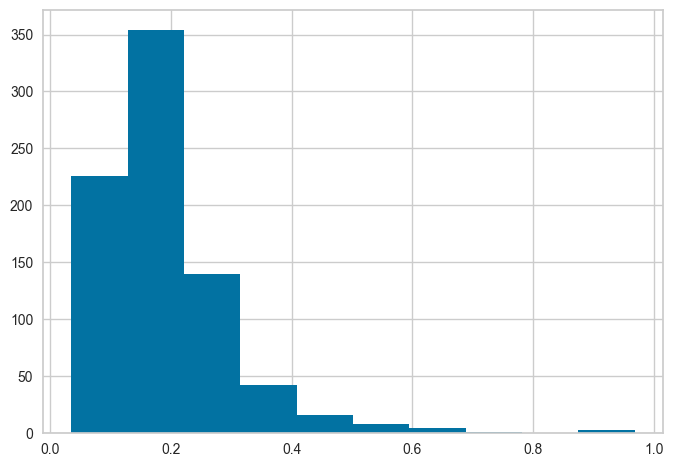

In [33]:
amount_spent_customer = global_superstore.groupby("customer_id").agg(
                                            total_discounted_price=("discounted_price","sum"),
                                            total_spent=("sales","sum")
                                            ).assign(median_discount=lambda df: df["total_discounted_price"]/df["total_spent"])
amount_spent_customer["median_discount"].hist()

##### Option 2 - Correlation of spending with discounts

discount_corr
customer_id               
AA-10315          0.045609
AA-10375         -0.072842
AA-10480          0.130095
AA-10645          0.100239
AB-10015          0.244514

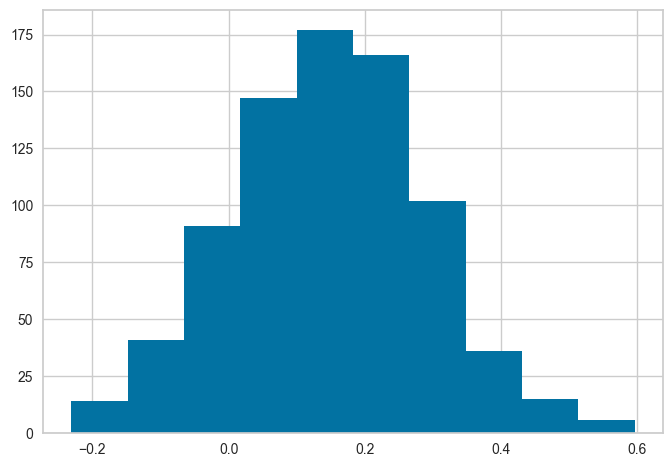

In [34]:

# groupby client and calculate
corr_client = global_superstore.groupby('customer_id').apply(calculate_discount_expense_correlation).reset_index()
corr_client.columns = ['customer_id', 'discount_corr']
corr_client.set_index("customer_id",inplace=True)
corr_client['discount_corr'].hist()
corr_client.head()

<Axes: xlabel='discounted_price', ylabel='sales'>

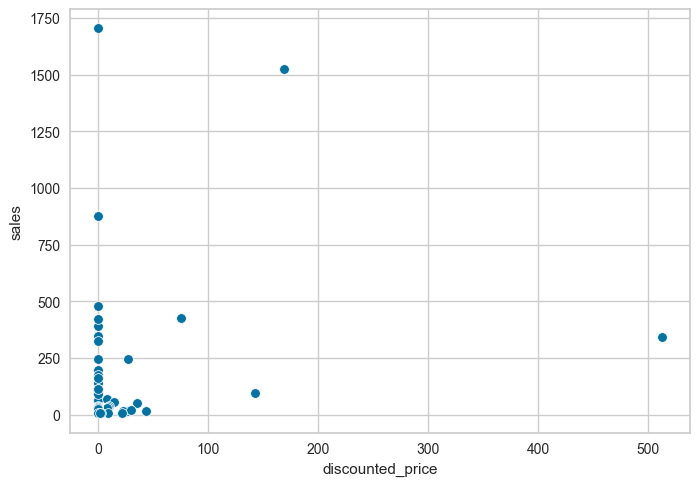

In [35]:
sns.scatterplot(data=global_superstore[global_superstore["customer_id"]=="EB-13750"],
                x="discounted_price",
                y="sales")

#### median quantity per order, median ppu per order & median discount

In [79]:
median_q_ppu_discount_order = (global_superstore.groupby(["customer_id", "order_id"]
                    ).agg(
                        total_spending_order=("sales", "sum"),
                        total_quantity=("quantity", "sum"),
                        total_discounted_price=("discounted_price","sum"))
                    .groupby("customer_id")
                    .agg(
                        median_spending_order=("total_spending_order", "median"),
                        median_quantity_order=("total_quantity","median")))

median_q_ppu_discount_order["median_unit_price"] = median_q_ppu_discount_order["median_spending_order"] / median_q_ppu_discount_order["median_quantity_order"]
median_q_ppu_discount_order[["median_unit_price","median_quantity_order"]] = median_q_ppu_discount_order[["median_unit_price","median_quantity_order"]].astype("float")
median_q_ppu_discount_order.head()

median_spending_order  median_quantity_order  median_unit_price
customer_id                                                                 
AA-10315                   270.600                    4.5          60.133333
AA-10375                    90.480                    4.0          22.620000
AA-10480                   386.520                    5.0          77.304000
AA-10645                   209.760                    6.0          34.960000
AB-10015                   309.592                    7.0          44.227429

#### Joining metrics

Version with median spending per order.

In [80]:
customer_aggregated_v1 = pd.concat([median_purchase_freq,median_ticket_order,
                                 amount_spent_customer["median_discount"],
                                 corr_client],axis=1)
print(f"The aggregated customer v1 df has {customer_aggregated_v1.shape[0]} rows")
customer_aggregated_v1.head()

The aggregated customer v1 df has 795 rows


median_orders_month  median_spending_order  median_shipping_cost  \
customer_id                                                                     
AA-10315                     1.0                270.600                32.955   
AA-10375                     1.0                 90.480                12.820   
AA-10480                     1.0                386.520                22.140   
AA-10645                     1.0                209.760                19.550   
AB-10015                     1.0                309.592                51.970   

             median_discount  discount_corr  
customer_id                                  
AA-10315            0.128051       0.045609  
AA-10375            0.213364      -0.072842  
AA-10480            0.104899       0.130095  
AA-10645            0.192877       0.100239  
AB-10015            0.154170       0.244514

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

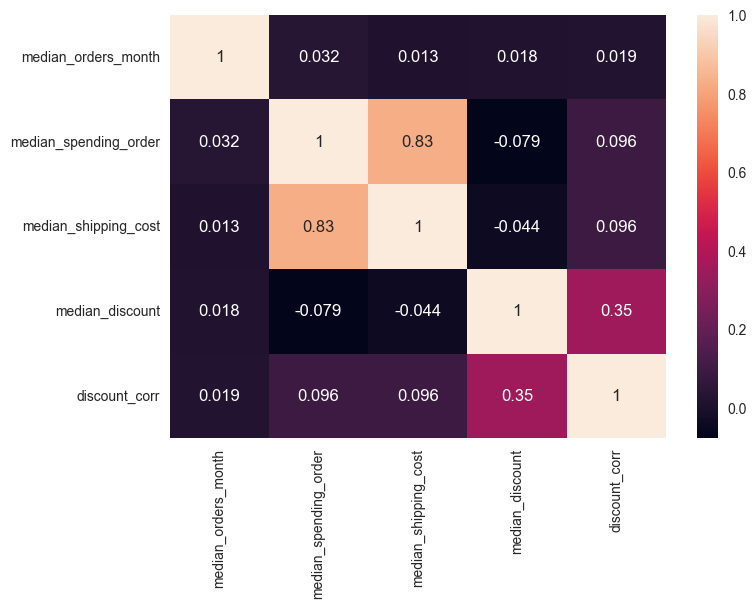

In [81]:
sns.heatmap(customer_aggregated_v1.corr(),annot=True)

Version with median ppu price and median quantity.

In [82]:
customer_aggregated_v2 = pd.concat([median_purchase_freq,median_ticket_order["median_shipping_cost"],
                                    median_q_ppu_discount_order[["median_unit_price","median_quantity_order"]],
                                 amount_spent_customer["median_discount"],
                                 corr_client],axis=1)
print(f"The aggregated customer v1 df has {customer_aggregated_v2.shape[0]} rows")
customer_aggregated_v2.head()

The aggregated customer v1 df has 795 rows


median_orders_month  median_shipping_cost  median_unit_price  \
customer_id                                                                 
AA-10315                     1.0                32.955          60.133333   
AA-10375                     1.0                12.820          22.620000   
AA-10480                     1.0                22.140          77.304000   
AA-10645                     1.0                19.550          34.960000   
AB-10015                     1.0                51.970          44.227429   

             median_quantity_order  median_discount  discount_corr  
customer_id                                                         
AA-10315                       4.5         0.128051       0.045609  
AA-10375                       4.0         0.213364      -0.072842  
AA-10480                       5.0         0.104899       0.130095  
AA-10645                       6.0         0.192877       0.100239  
AB-10015                       7.0         0.154170       0.244514

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

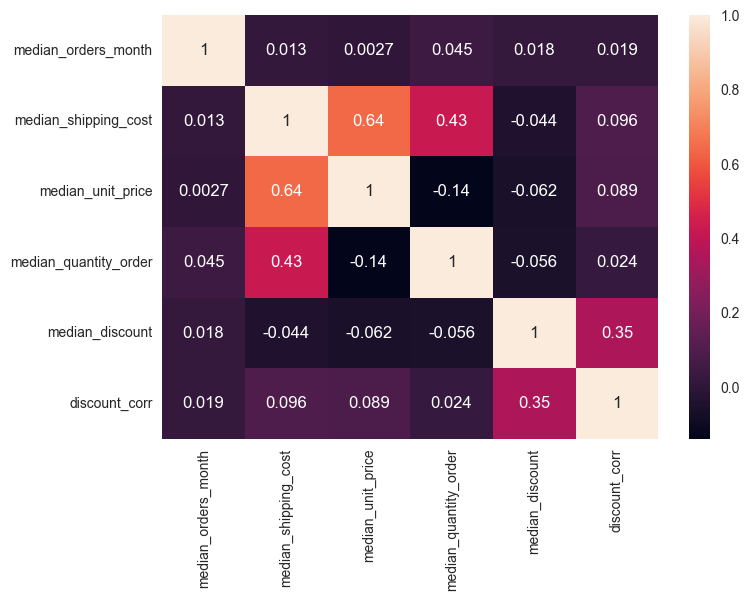

In [83]:
sns.heatmap(customer_aggregated_v2.corr(),annot=True)

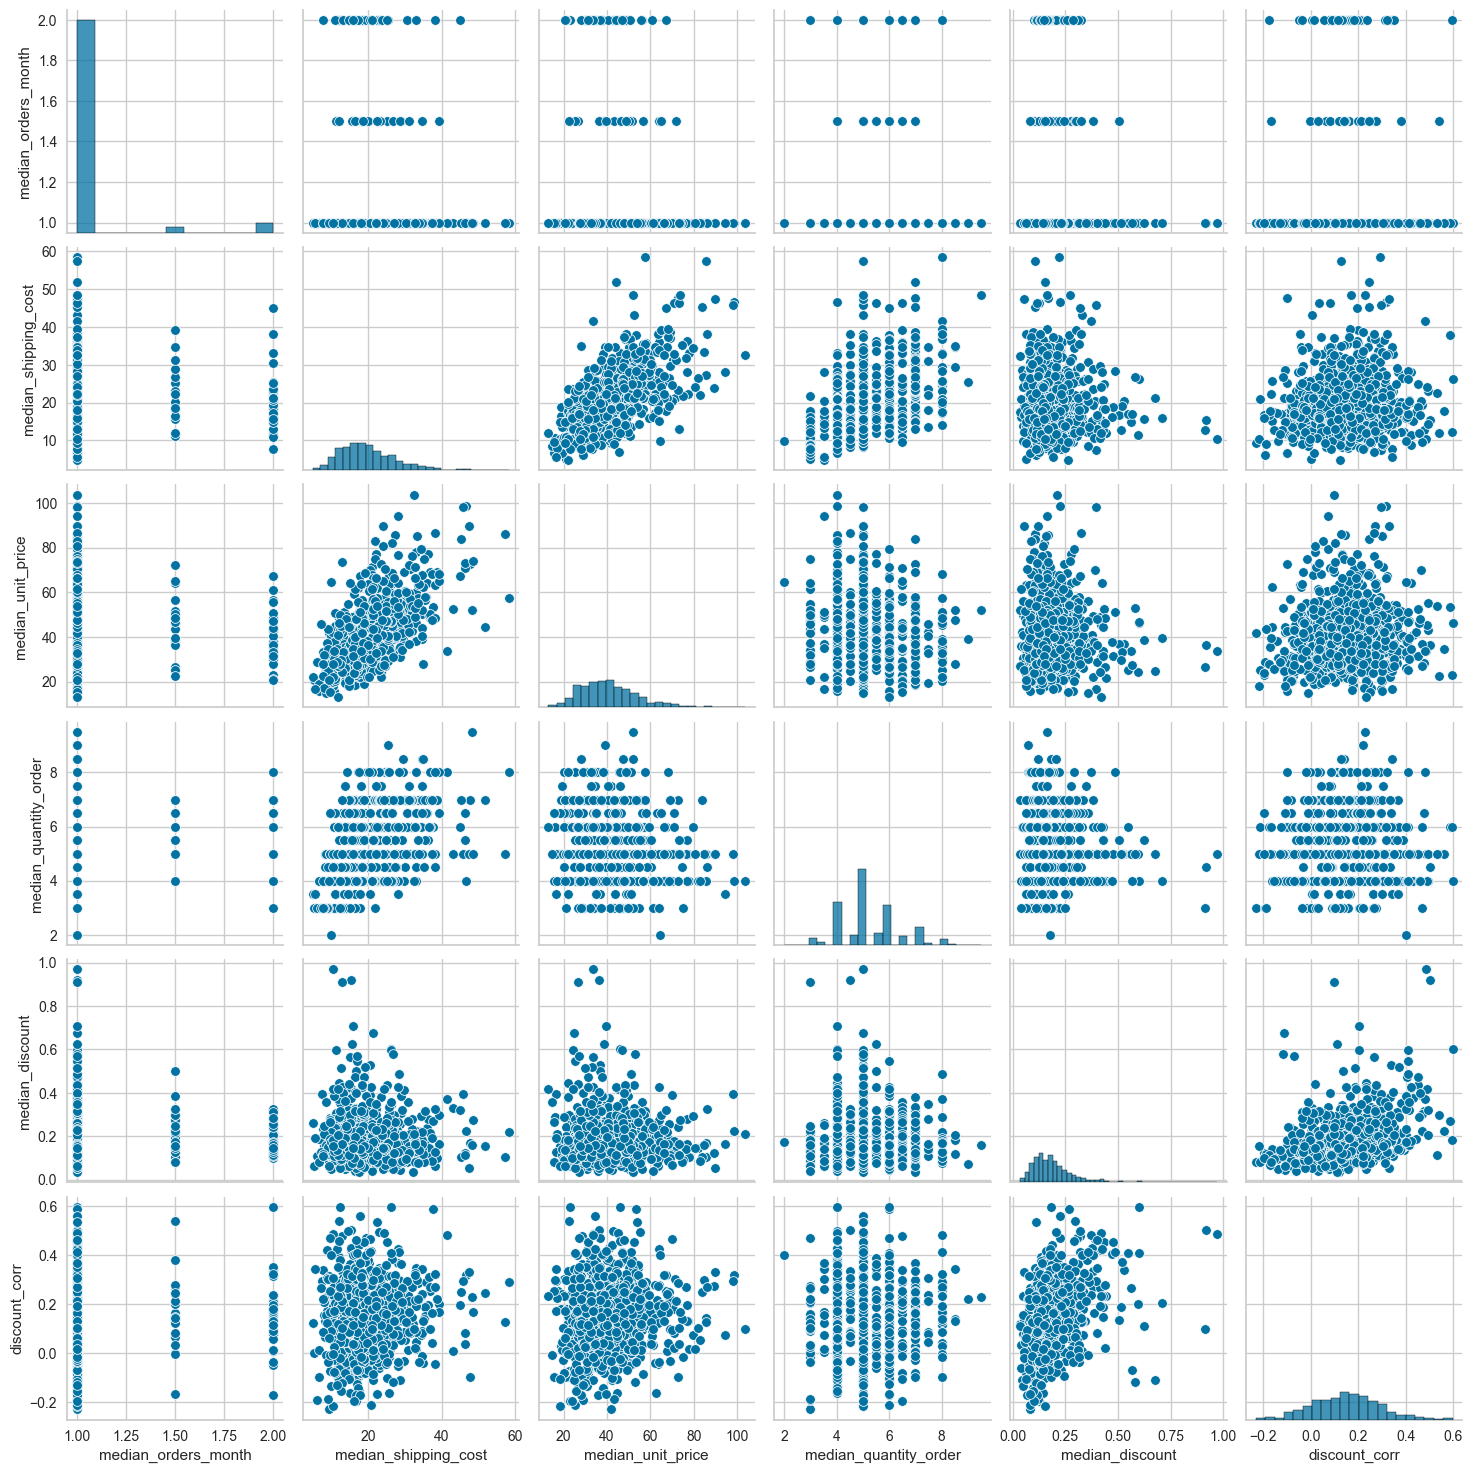

In [84]:
sns.pairplot(customer_aggregated_v2)

#### Adding categorical column segment

This column is the only categorical one that makes straight sense, because all others would be an approximation through frequencies. Those could be fine, might they might also obscure the relationships between feautures for clustering.

In [85]:
customer_segment = global_superstore.groupby("customer_id").agg(segment=("segment","first"))

#### Join to metrics subsets

In [86]:
customer_aggregated_v1 = pd.concat([customer_aggregated_v1,customer_segment],axis=1)
customer_aggregated_v2 = pd.concat([customer_aggregated_v2,customer_segment],axis=1)

## 2.3 Preprocessing

Preprocessing should include categorical encoding, outlier handling and feature scaling. As for this iteration only numerical features are included, only feature scaling and outlier handling are needed.

#### Outlier handling

Contamination set to 3%.

Handle customer_aggregated_v1 first, then v2.

In [87]:
# detect v1
gestor_outliers = so.GestionOutliersMultivariados(customer_aggregated_v1)

customer_aggregated_v1_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.05).replace({"outlier":{1:0,-1:1}})


# detect v2
gestor_outliers = so.GestionOutliersMultivariados(customer_aggregated_v2)

customer_aggregated_v2_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.05).replace({"outlier":{1:0,-1:1}})

Inspecting the results via pairplots:

Pairplot of version 1


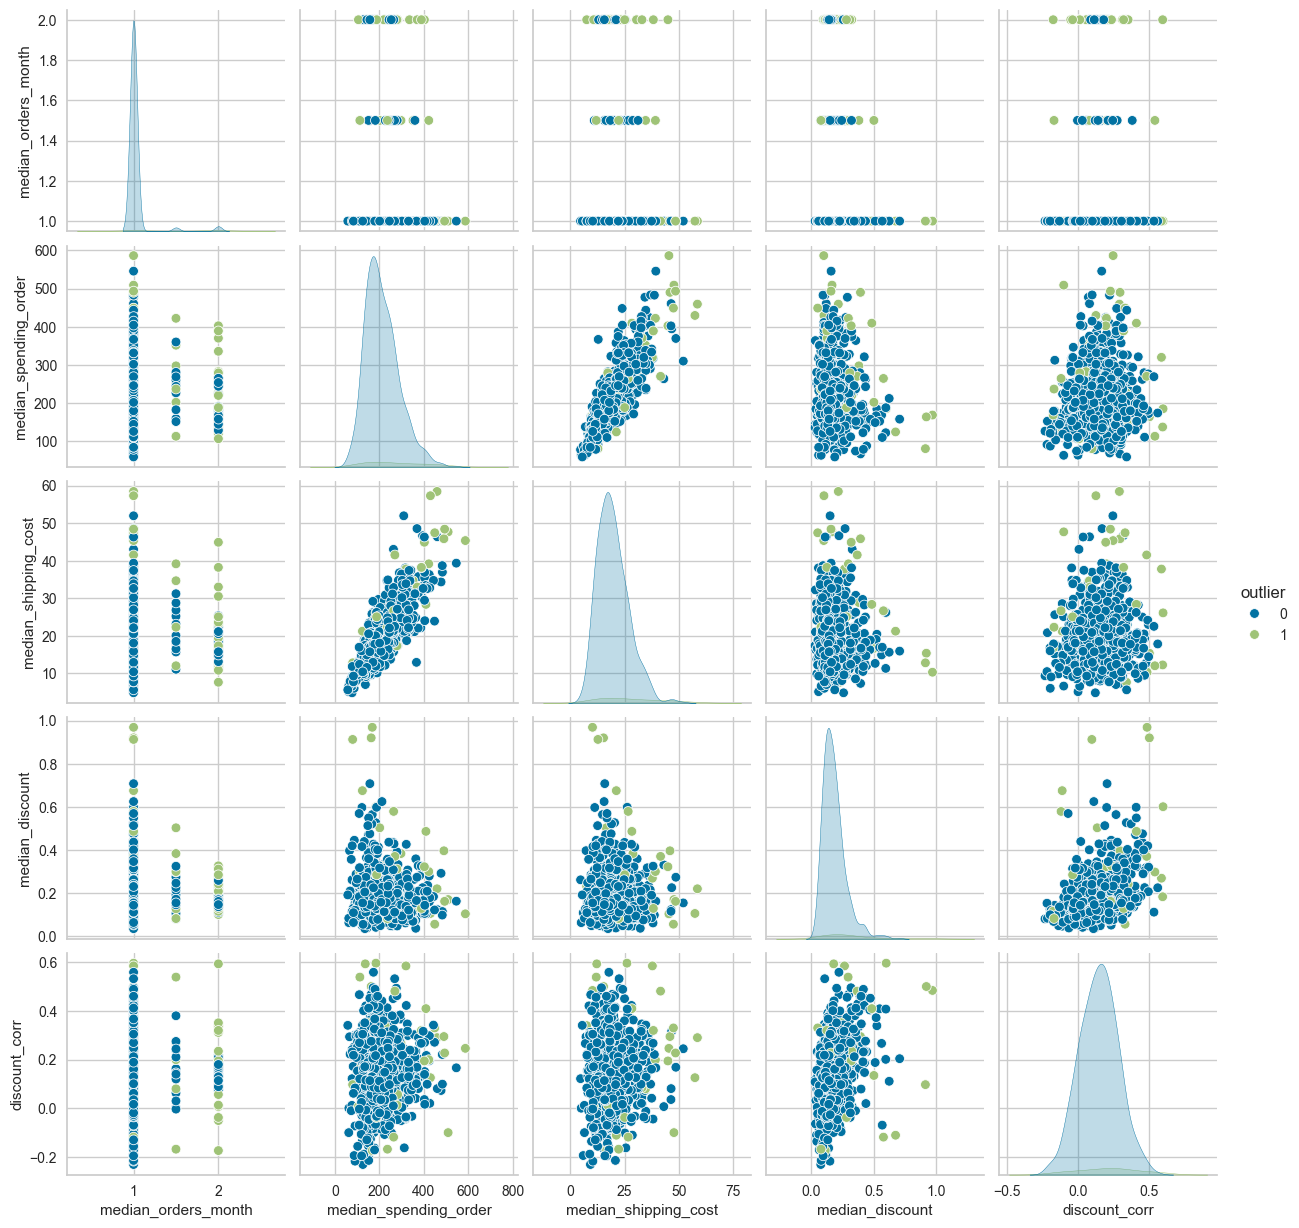



Pairplot of version 2


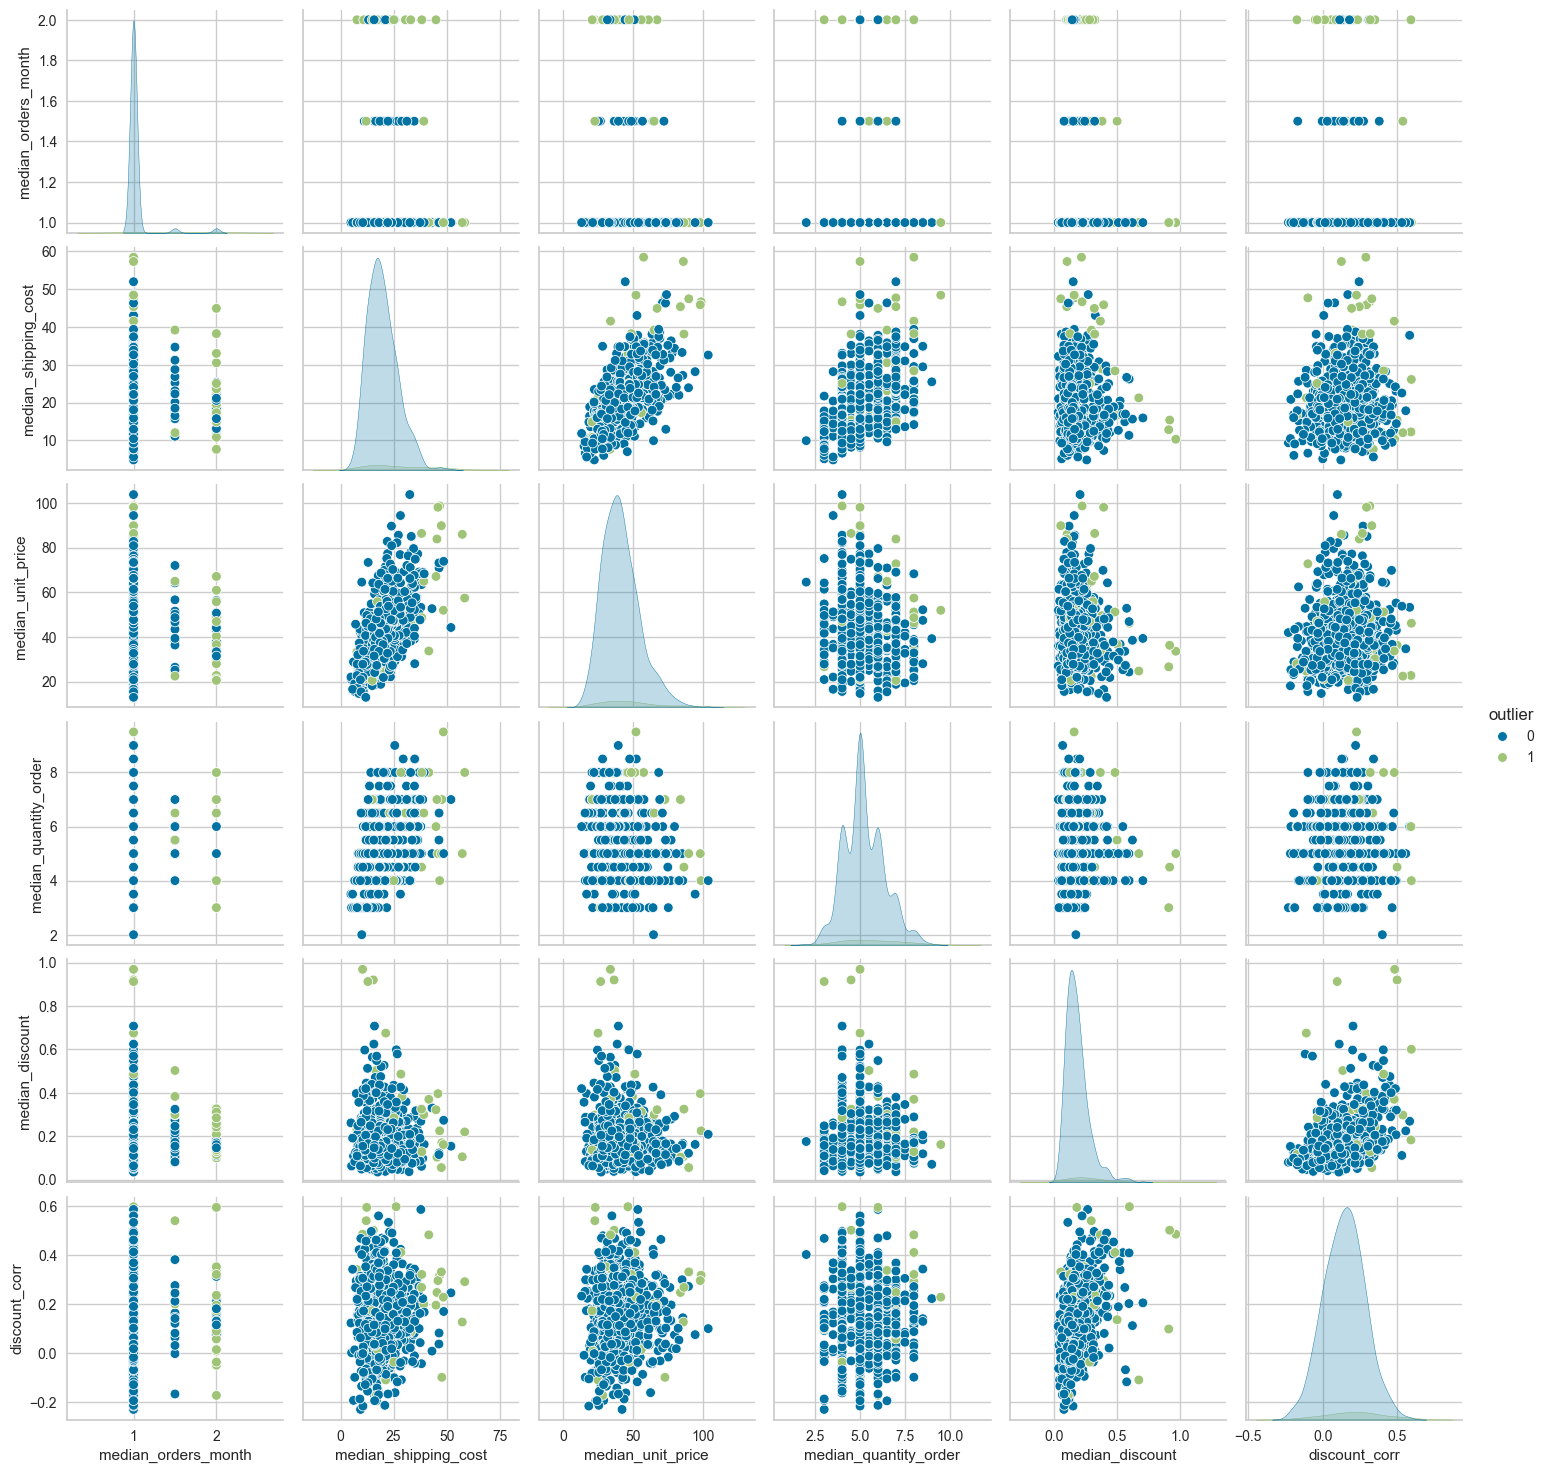

In [88]:
print("Pairplot of version 1") # cannot use titles apparently
sns.pairplot(customer_aggregated_v1_outliers, hue="outlier")
plt.show()

print("\n\nPairplot of version 2")
sns.pairplot(customer_aggregated_v2_outliers, hue="outlier")
plt.show()

Outliers detected visually look correct. To not introduce noise into the model, these records are better left out of the clustering process. Therefore:

In [89]:
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers[customer_aggregated_v1_outliers["outlier"]==0].drop(columns="outlier")

customer_aggregated_v2_outliers = customer_aggregated_v2_outliers[customer_aggregated_v2_outliers["outlier"]==0].drop(columns="outlier")

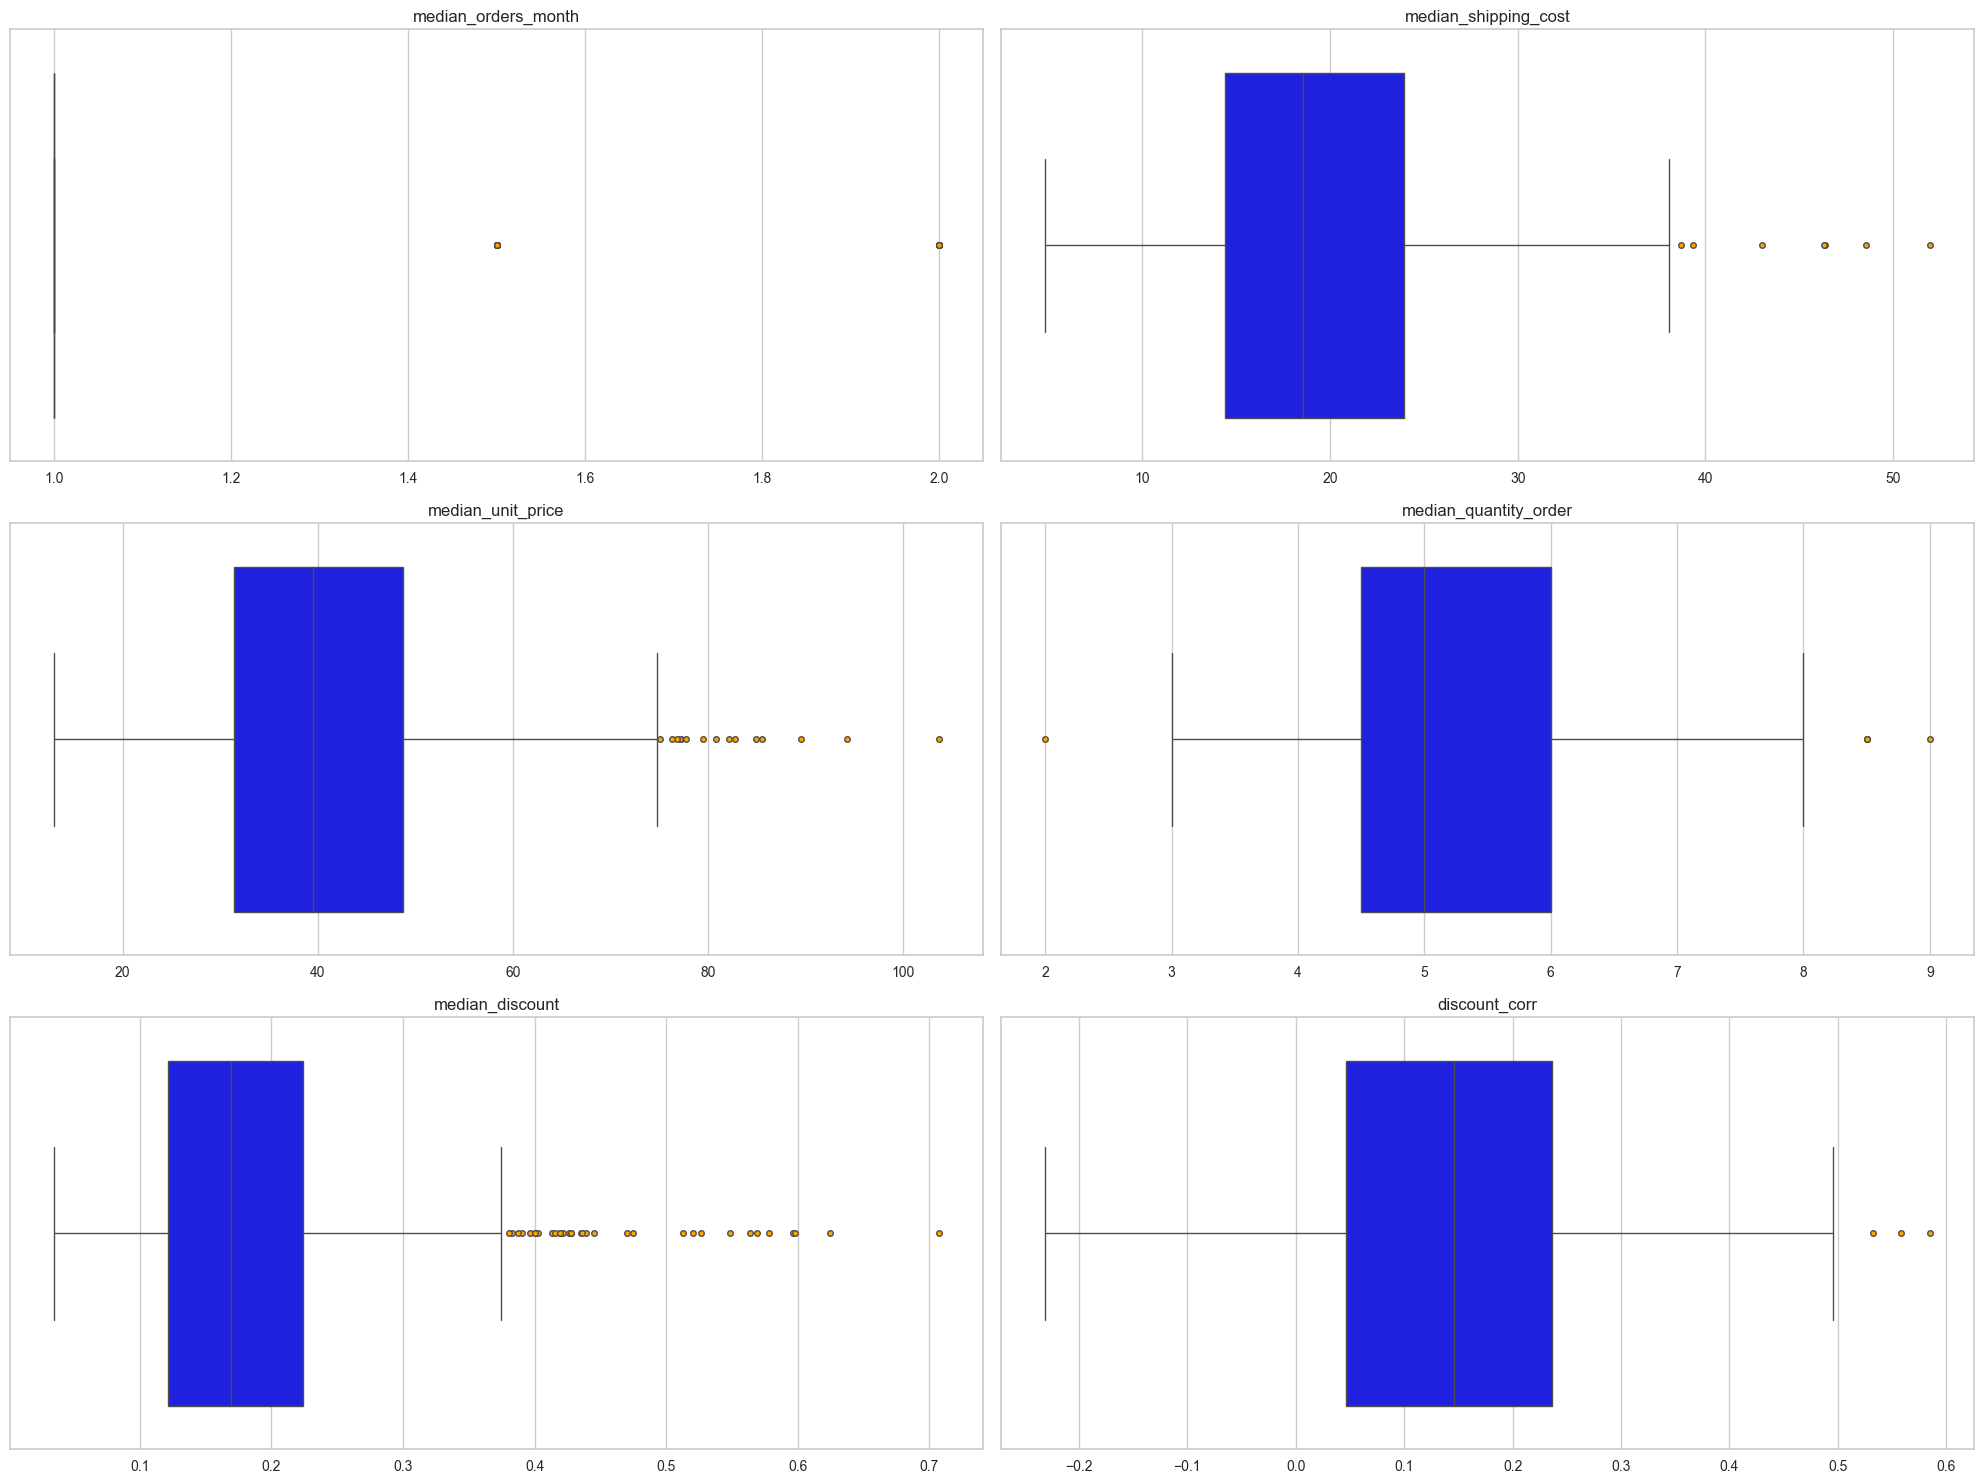

In [91]:
gestor_outliers_v2 = so.GestionOutliersUnivariados(customer_aggregated_v2_outliers)

gestor_outliers_v2.visualizar_outliers_univariados()

#### Encoding

Frequency encoding is the one that inherently only inserts information about the feature inside itself, thefore, is the go to solution for the customer segment feature. 

In [98]:
frequency_map = customer_aggregated_v1_outliers['segment'].value_counts(normalize=True) 
customer_aggregated_v2_outliers['segment'] = customer_aggregated_v2_outliers['segment'].map(frequency_map)
customer_aggregated_v1_outliers['segment'] = customer_aggregated_v1_outliers['segment'].map(frequency_map)
customer_aggregated_v1_outliers.head()

median_orders_month  median_spending_order  median_shipping_cost  \
customer_id                                                                     
AA-10315                     1.0                270.600                32.955   
AA-10375                     1.0                 90.480                12.820   
AA-10480                     1.0                386.520                22.140   
AA-10645                     1.0                209.760                19.550   
AB-10015                     1.0                309.592                51.970   

             median_discount  discount_corr   segment  
customer_id                                            
AA-10315            0.128051       0.045609  0.512583  
AA-10375            0.213364      -0.072842  0.512583  
AA-10480            0.104899       0.130095  0.512583  
AA-10645            0.192877       0.100239  0.512583  
AB-10015            0.154170       0.244514  0.512583

##### Feature scaling

To retain the maximum information possible about distances, we use robust scaling.

In [100]:
customer_aggregated_v1_outliers['segment']

customer_id
AA-10315    0.512583
AA-10375    0.512583
AA-10480    0.512583
AA-10645    0.512583
AB-10015    0.512583
              ...   
XP-11865    0.512583
YC-11895    0.303311
YS-11880    0.303311
ZC-11910    0.512583
ZD-11925    0.512583
Name: segment, Length: 755, dtype: float64

In [116]:
empty_df = pd.DataFrame()
empty_df["segment"] = customer_aggregated_v1_outliers['segment']
empty_df["segment"]

customer_id
AA-10315    0.512583
AA-10375    0.512583
AA-10480    0.512583
AA-10645    0.512583
AB-10015    0.512583
              ...   
XP-11865    0.512583
YC-11895    0.303311
YS-11880    0.303311
ZC-11910    0.512583
ZD-11925    0.512583
Name: segment, Length: 755, dtype: float64

In [121]:
scaler = RobustScaler()

customer_aggregated_v1_scaled = pd.DataFrame(scaler.fit_transform(customer_aggregated_v1_outliers.iloc[:,:-1]),
                                             columns=customer_aggregated_v1_outliers.iloc[:,:-1].columns
                                             )
customer_aggregated_v1_scaled["segment"] = customer_aggregated_v1_outliers['segment'].values

customer_aggregated_v2_scaled = pd.DataFrame(scaler.fit_transform(customer_aggregated_v2_outliers.iloc[:,:-1]),
                                             columns=customer_aggregated_v2_outliers.iloc[:,:-1].columns)
customer_aggregated_v2_scaled["segment"] = customer_aggregated_v2_outliers['segment'].values

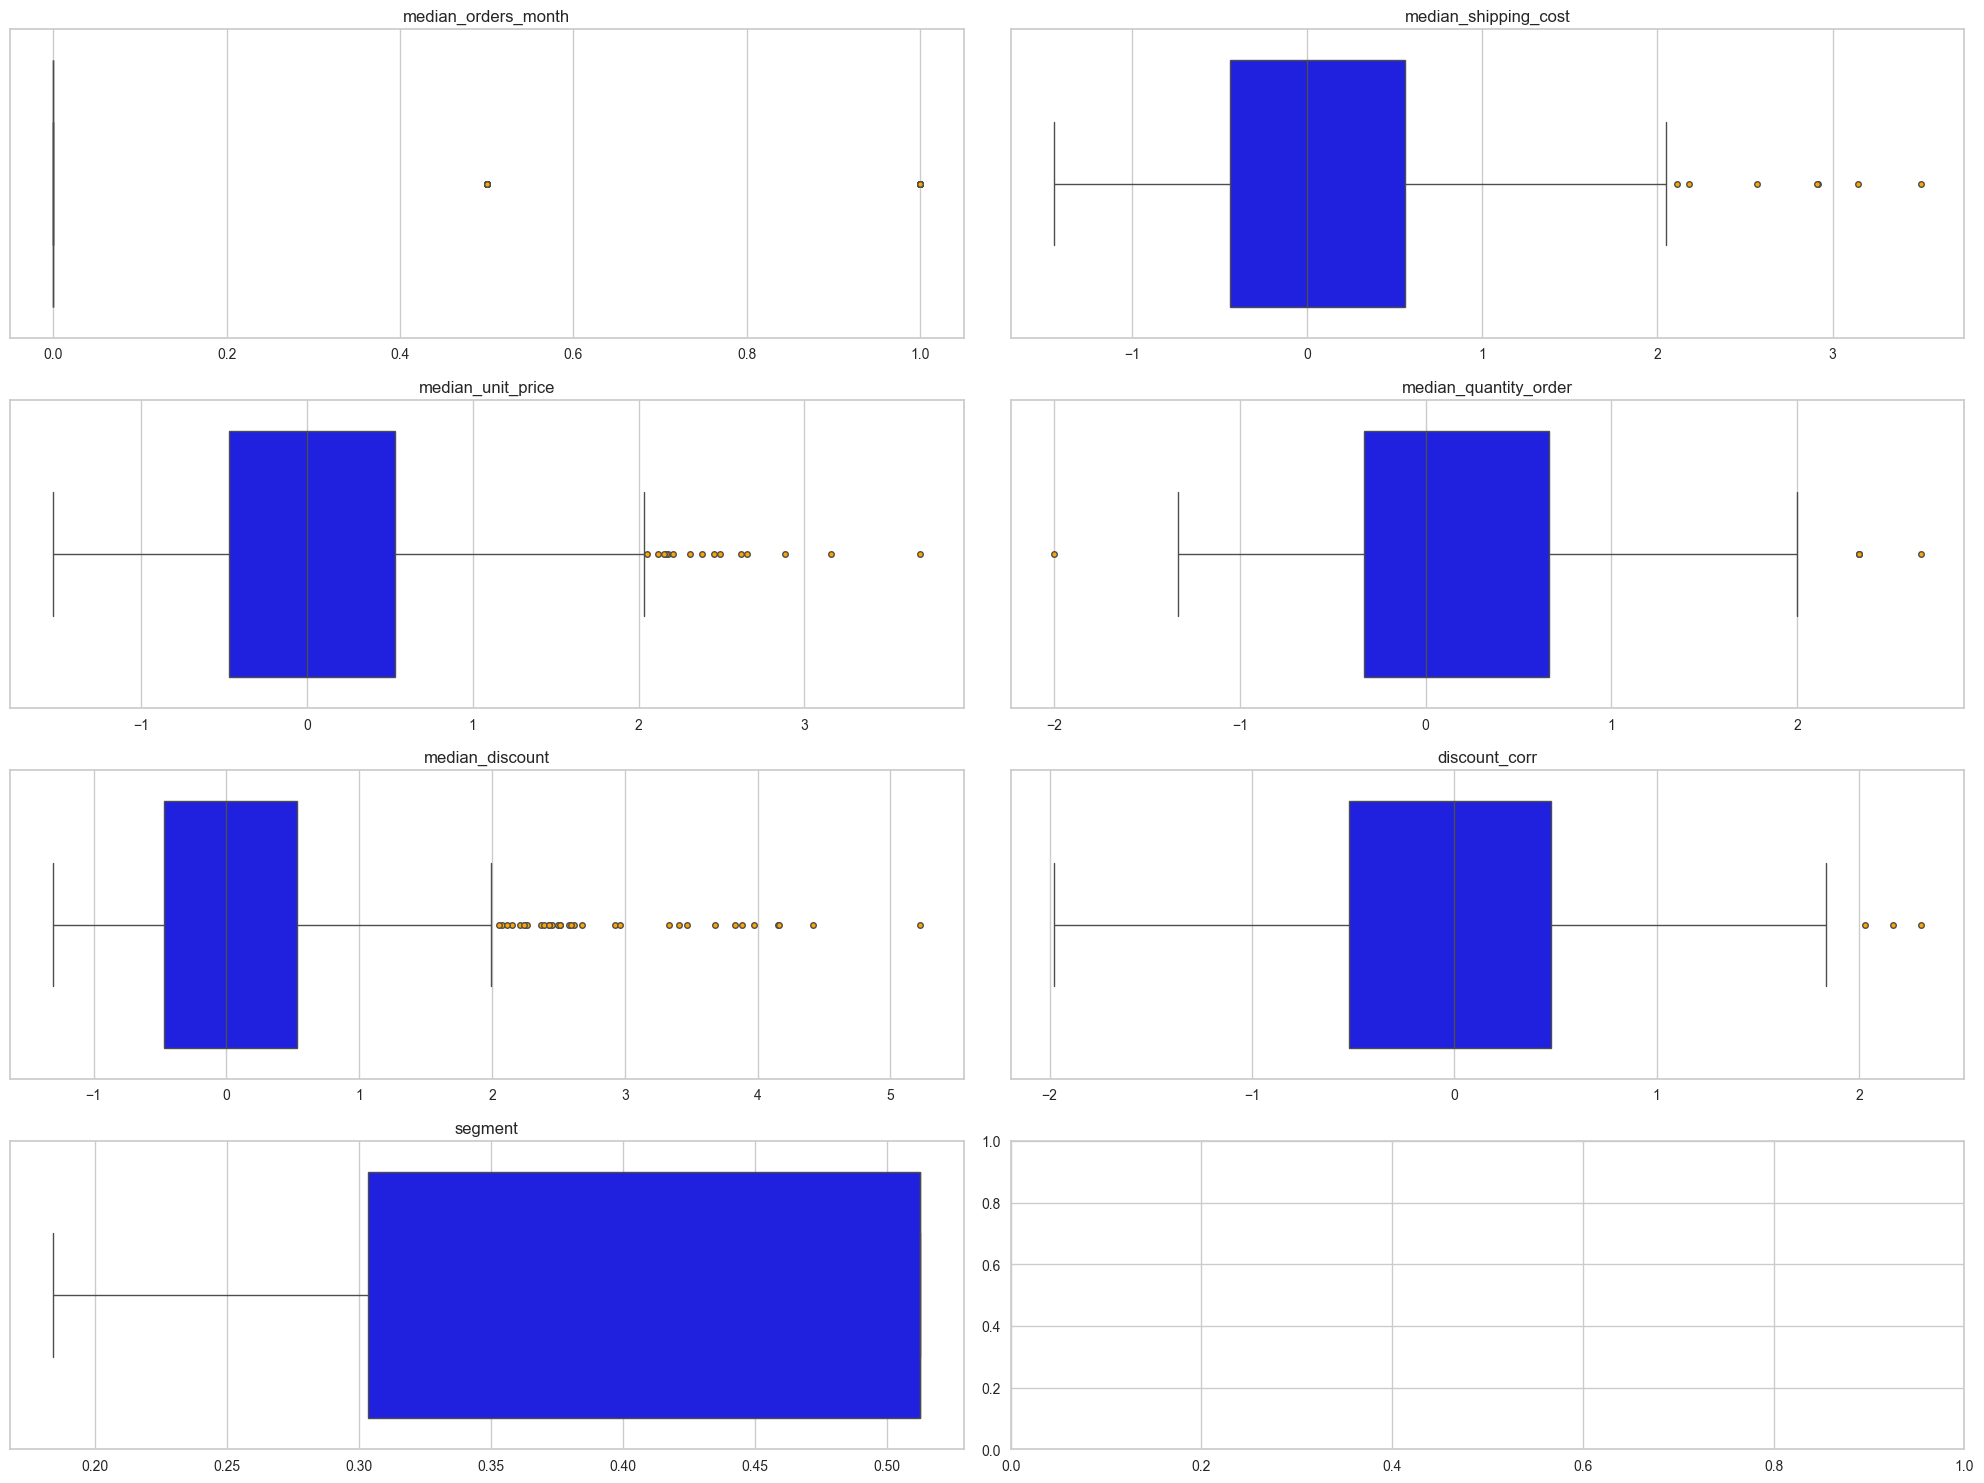

In [122]:
gestor_outliers_v2 = so.GestionOutliersUnivariados(customer_aggregated_v2_scaled)

gestor_outliers_v2.visualizar_outliers_univariados()

#### Visualize results

To get an intuition for the separability of the data, let's plot the pairplots for the scaled data.

Version 1 of customer aggregated data:

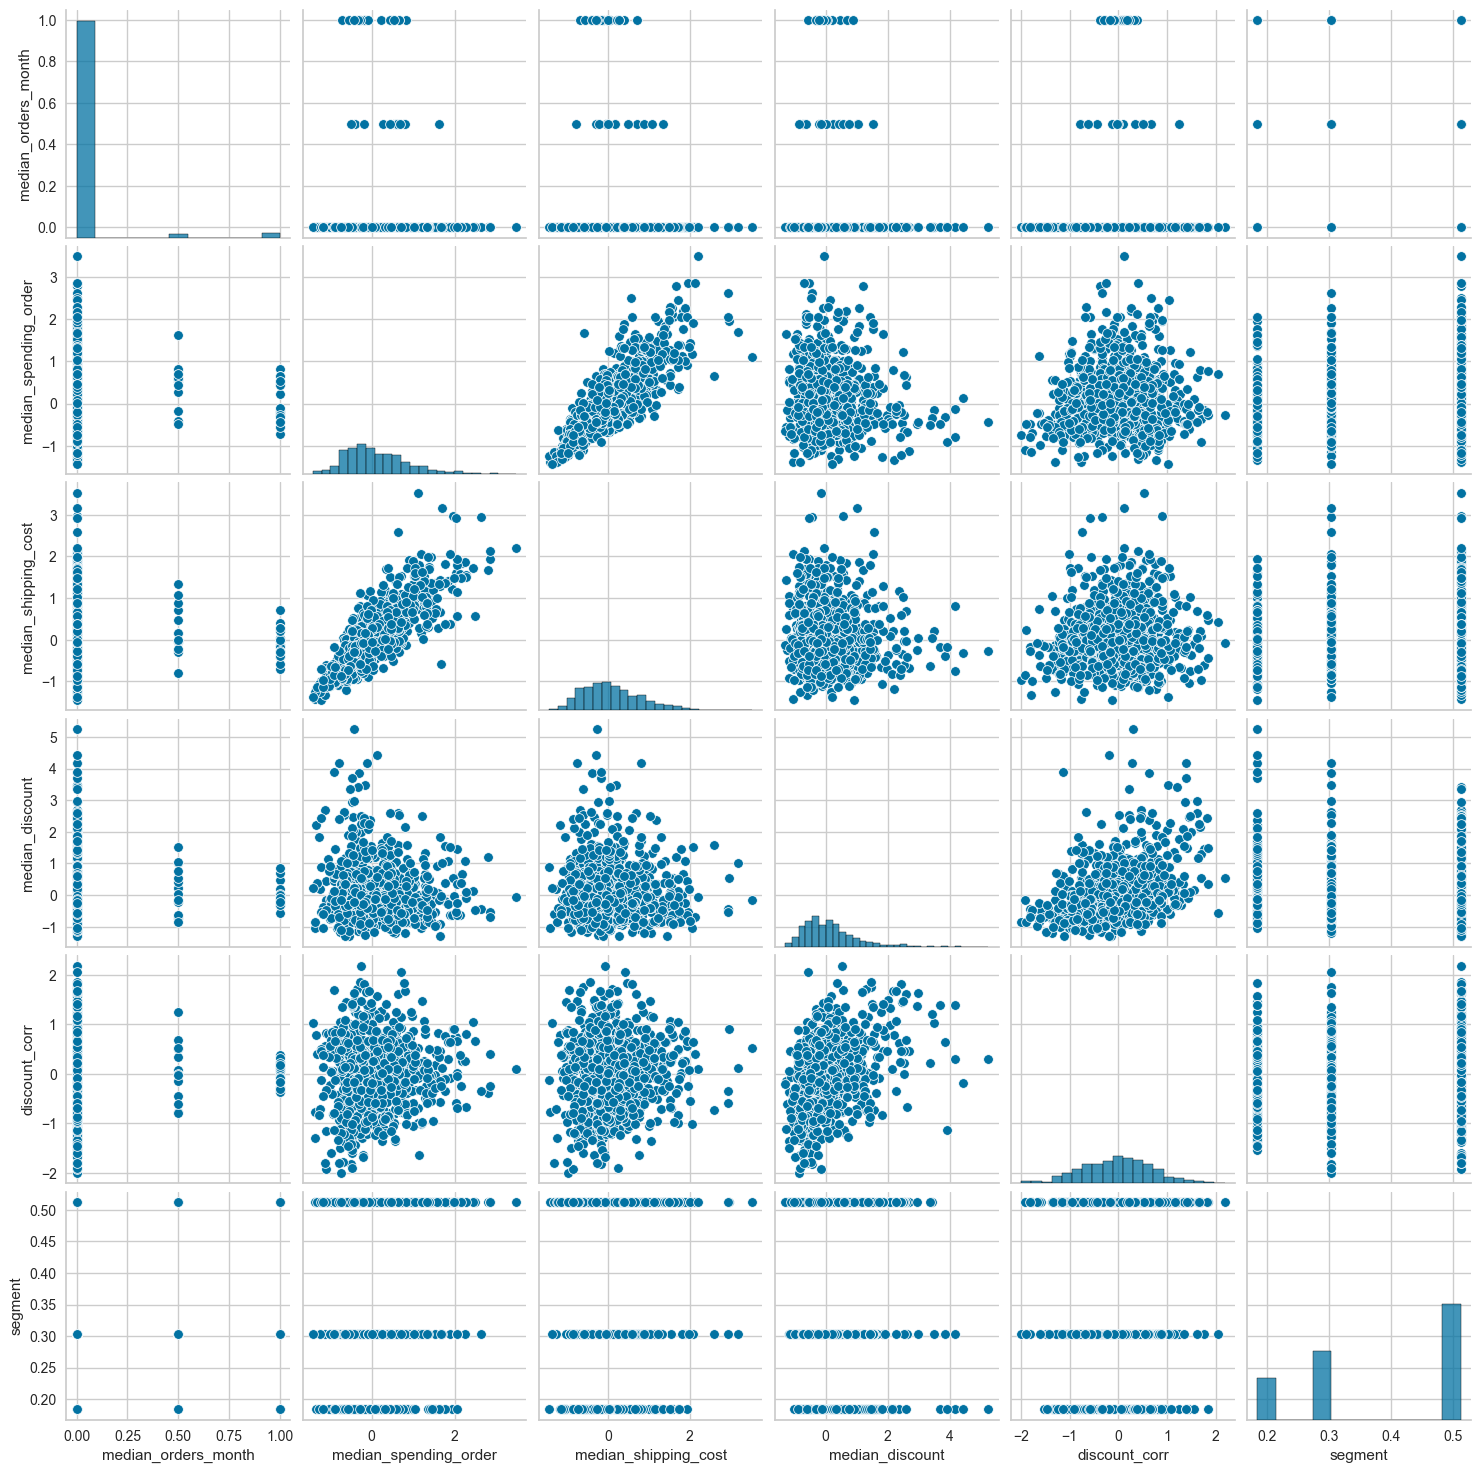

In [123]:
sns.pairplot(customer_aggregated_v1_scaled)

Version 2 of customer aggregated data:

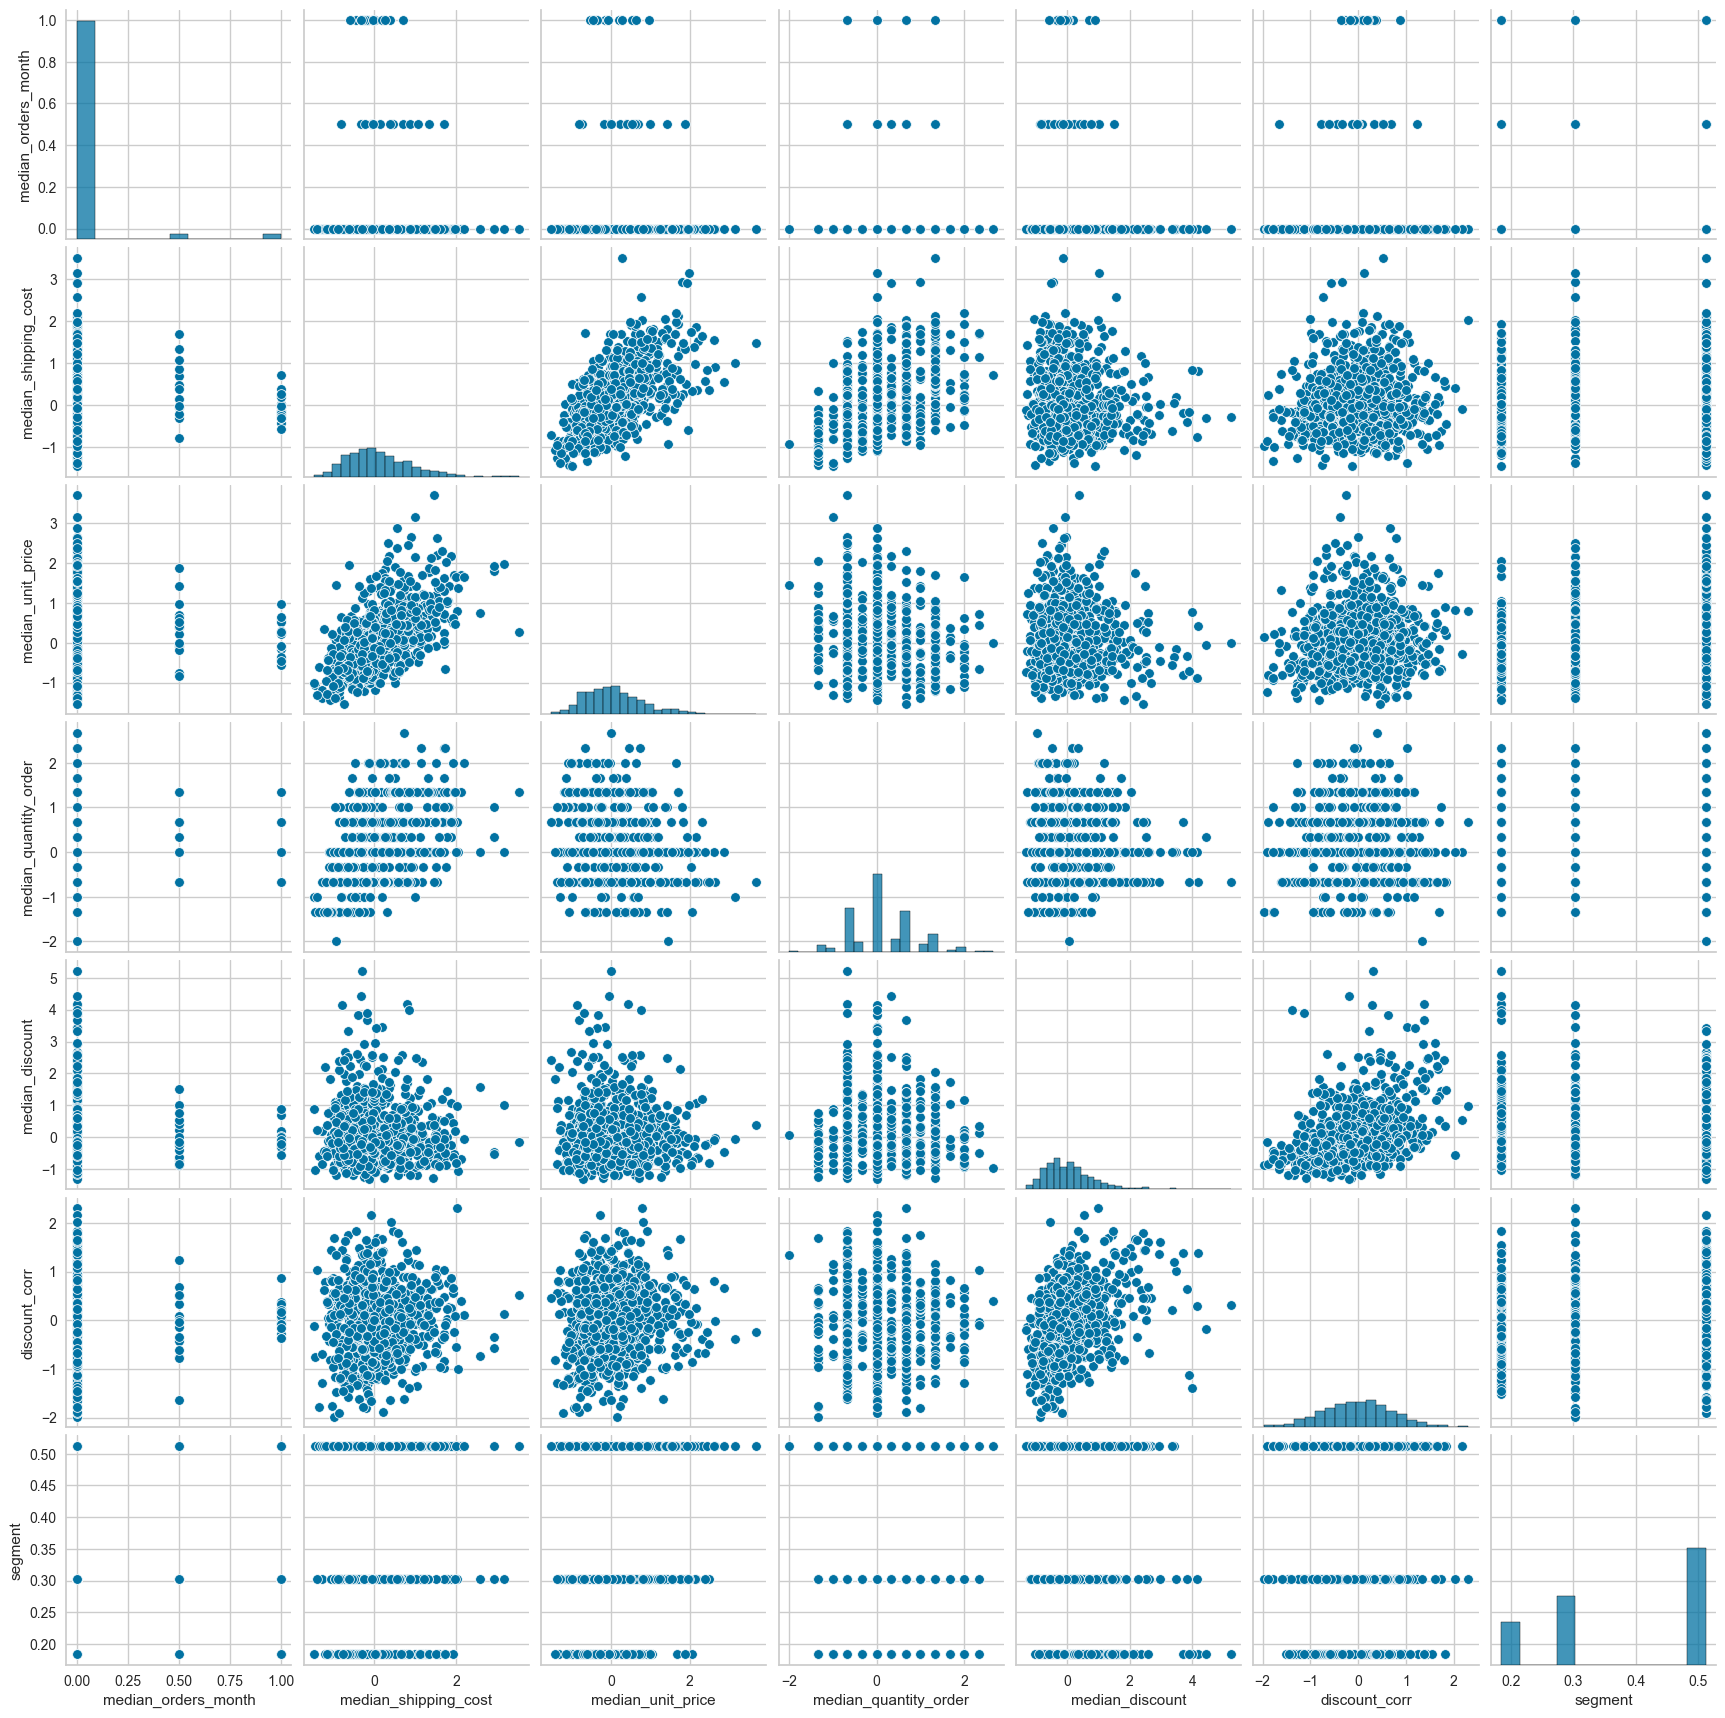

In [124]:
sns.pairplot(customer_aggregated_v2_scaled)

# 2.4 Clustering

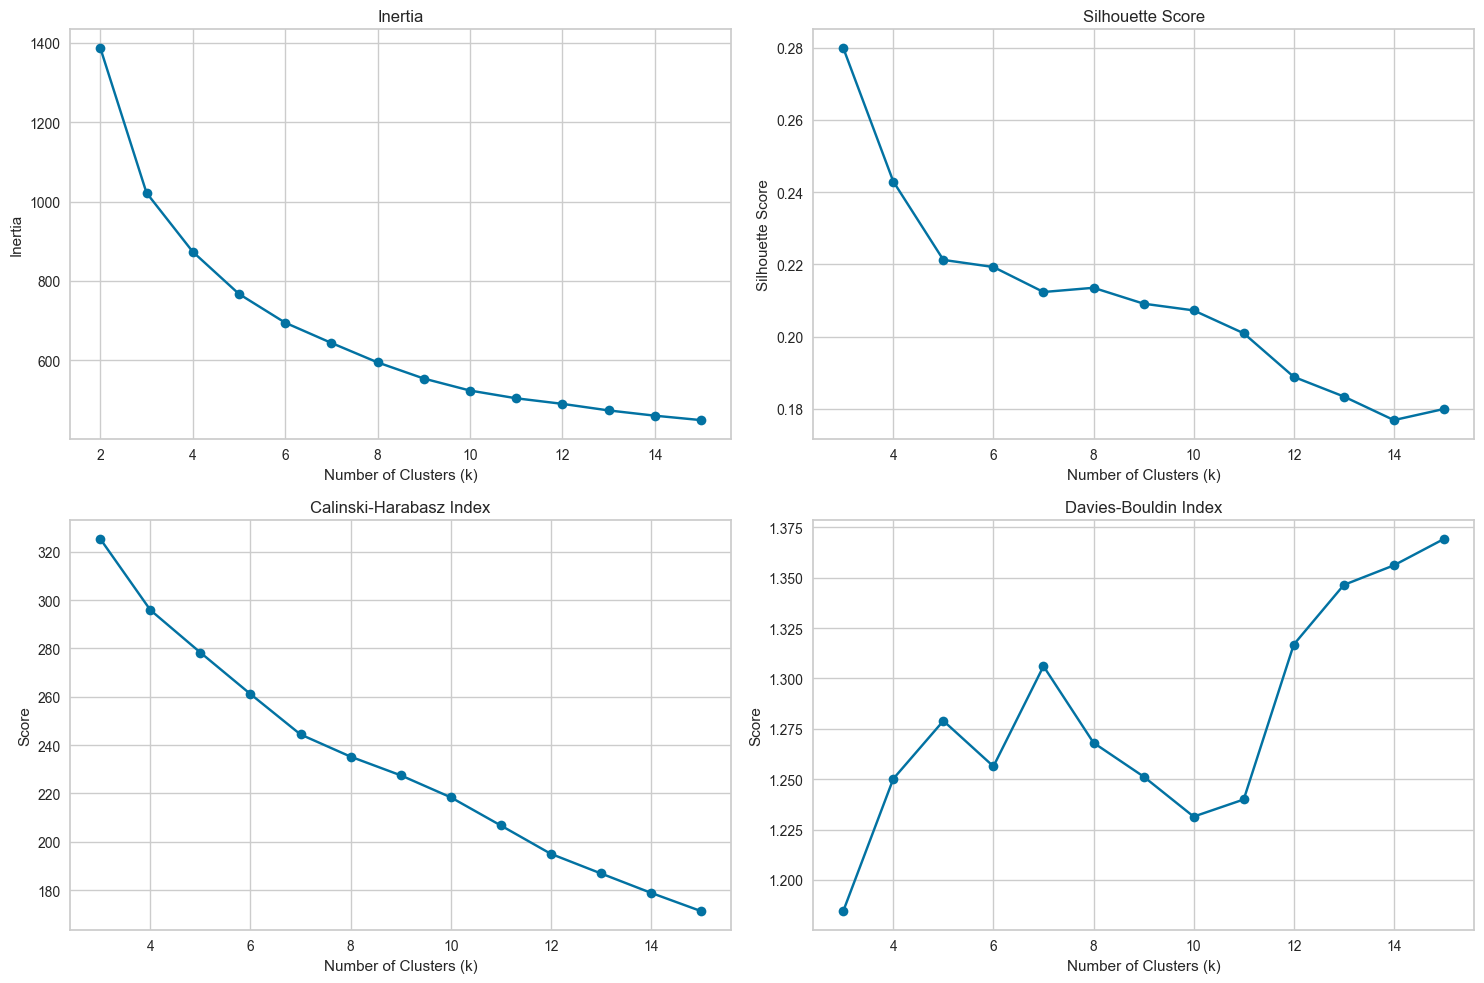

In [125]:
choose_kmeans_k(customer_aggregated_v1_scaled)

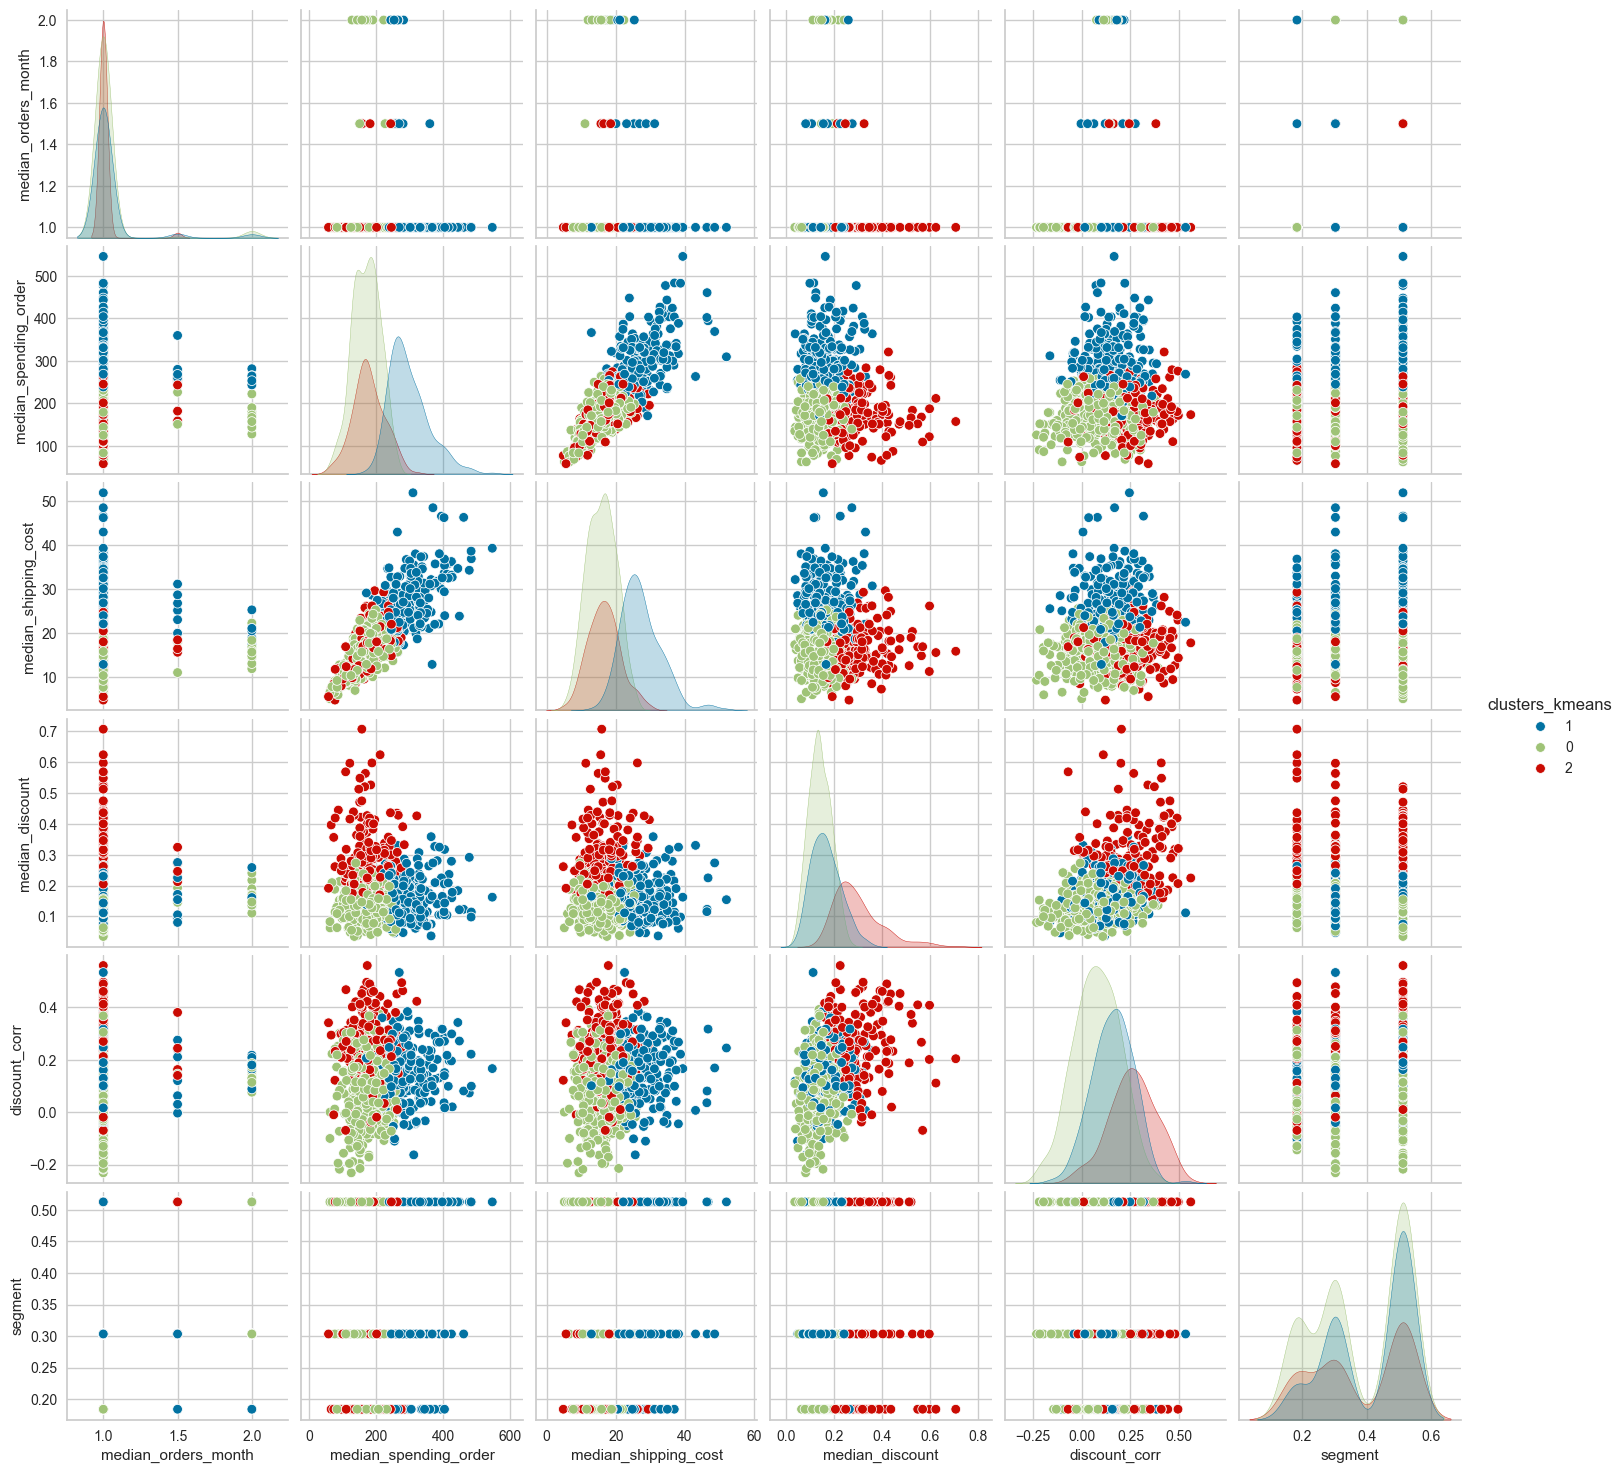

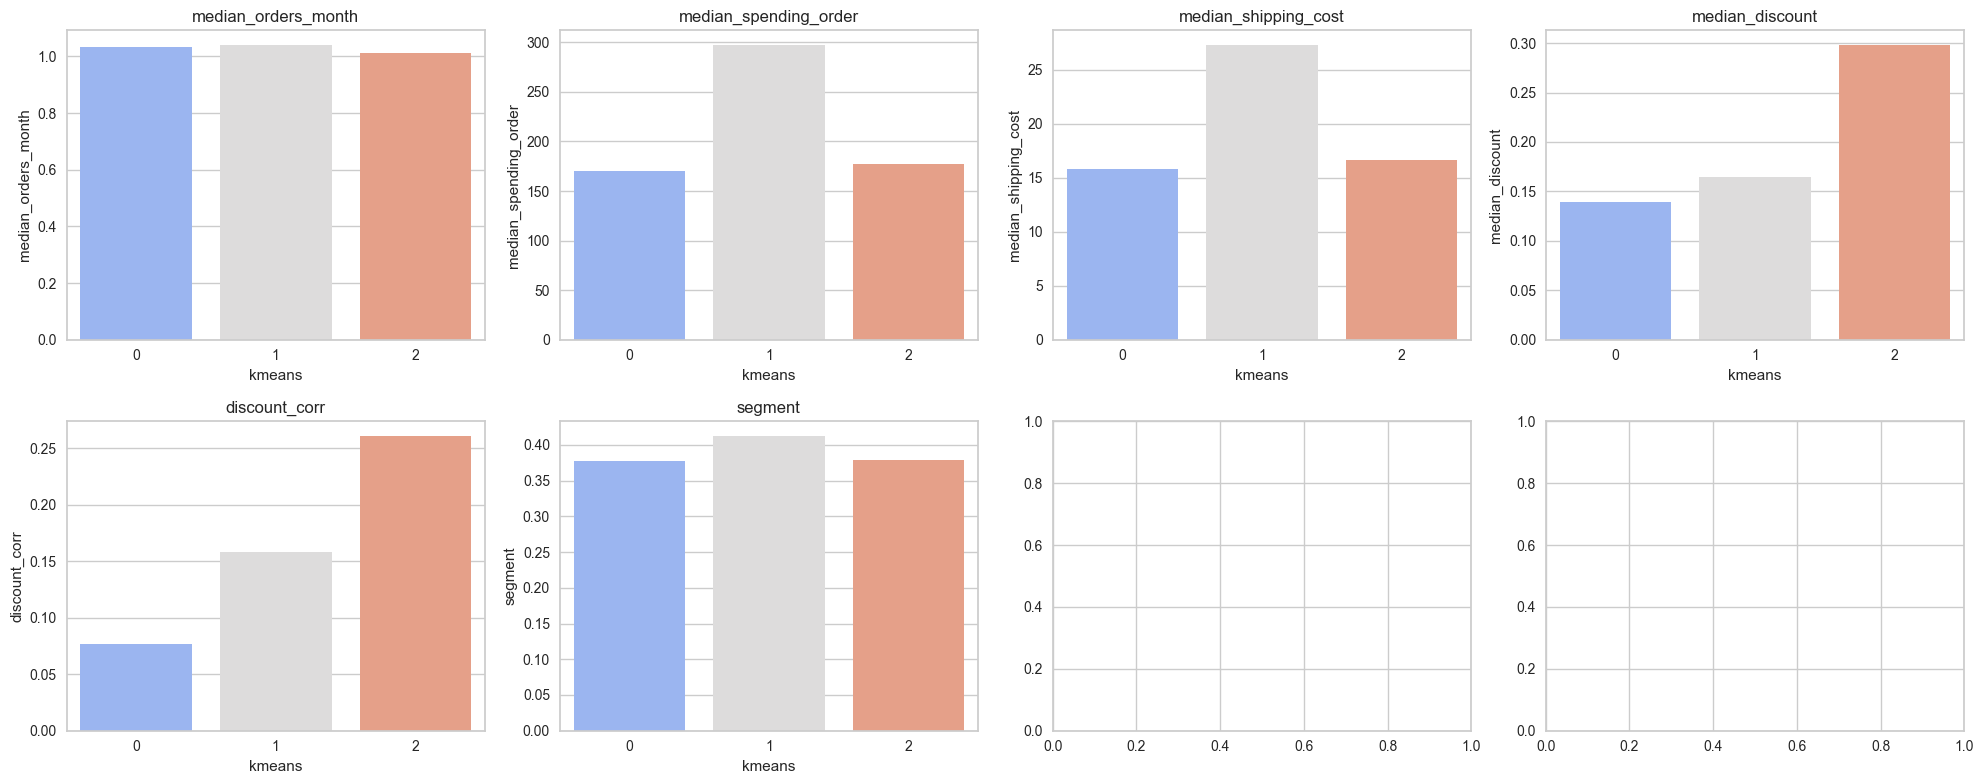

In [126]:
warnings.filterwarnings("ignore")
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers.astype("float")
clusterizador_v1 = sc.Clustering(customer_aggregated_v1_outliers)

# 
clusterizador_v1.preparar_dataframe(scaler="robust")

customer_aggregated_v2_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,3)

sns.pairplot(customer_aggregated_v2_clustered, hue="clusters_kmeans")

clusterizador_v1.plot_clusters("kmeans")
warnings.filterwarnings("default")

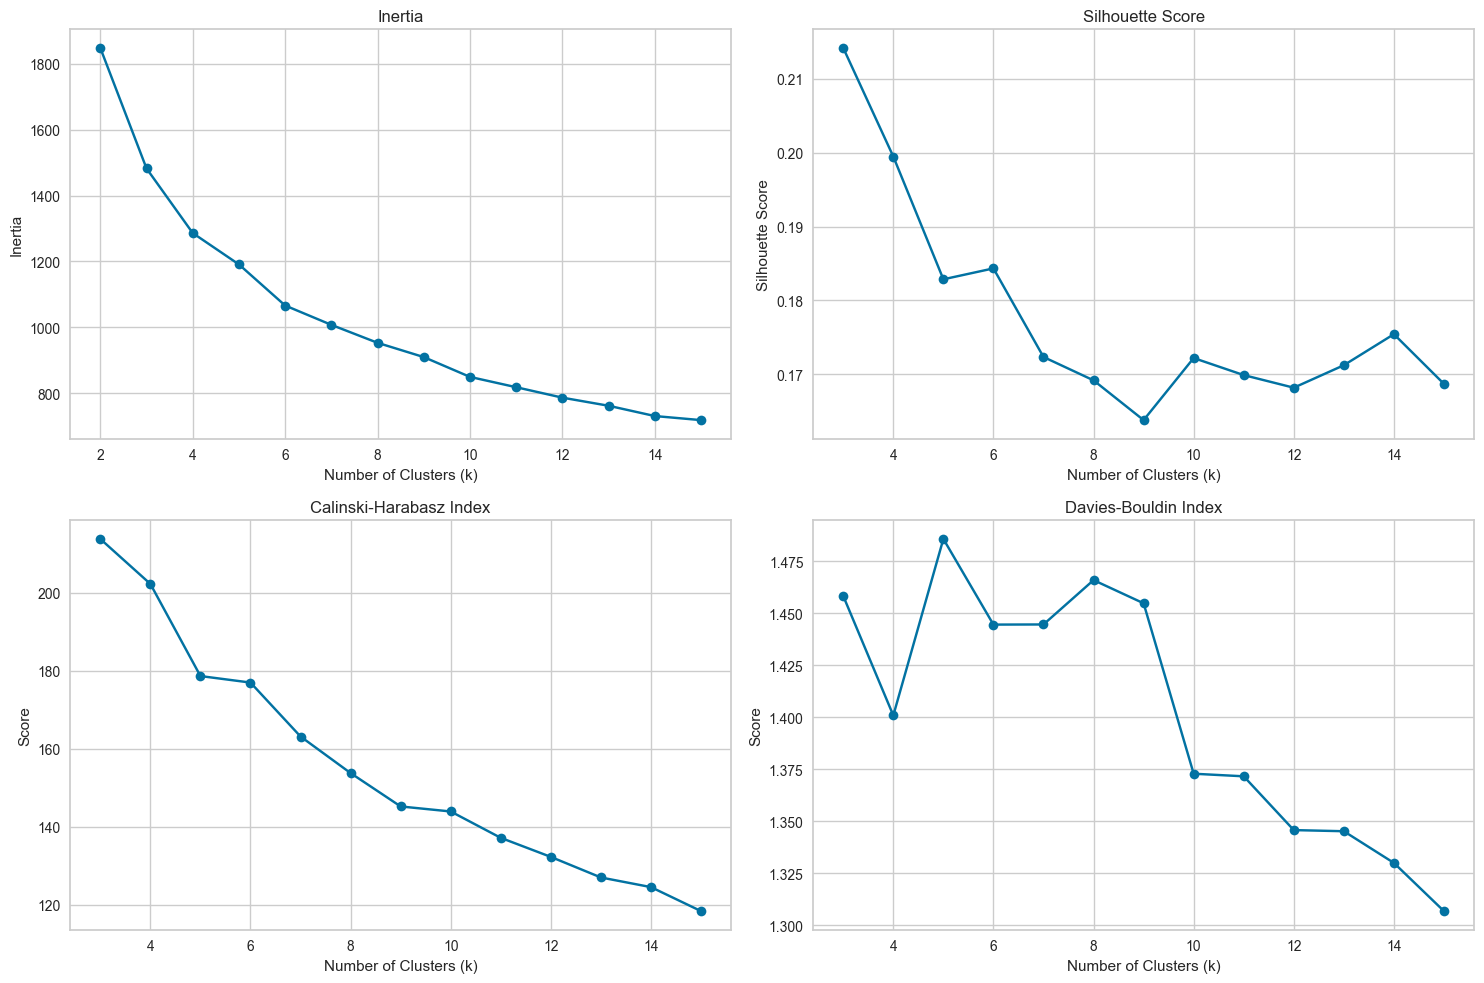

In [128]:
choose_kmeans_k(customer_aggregated_v2_scaled)

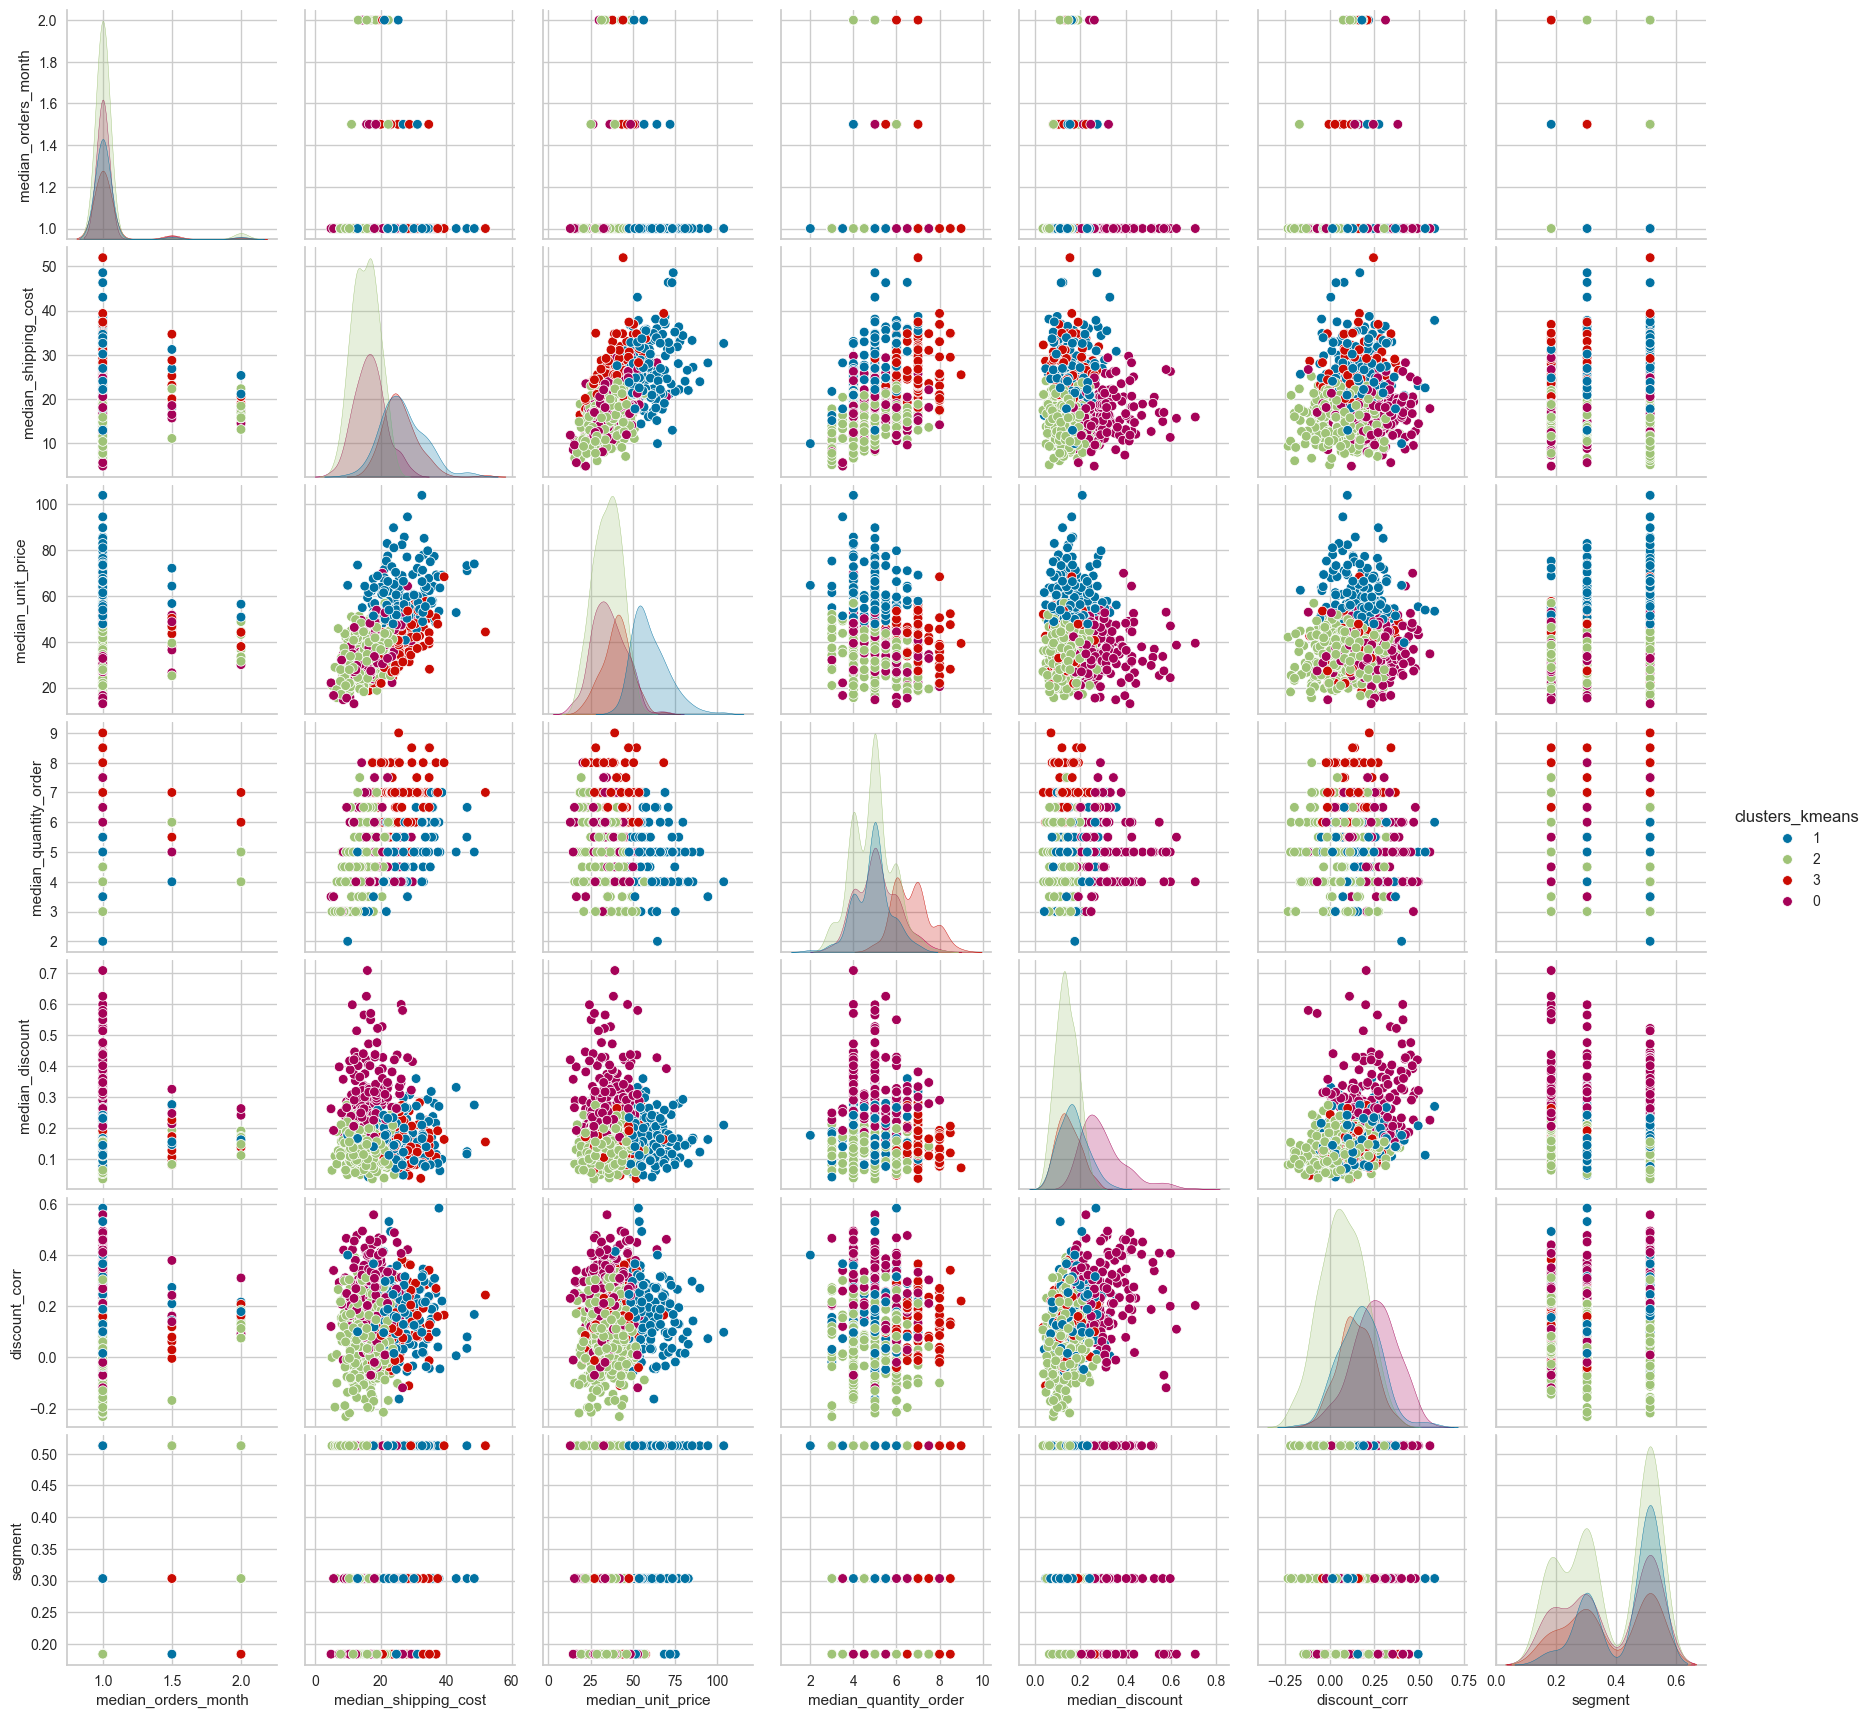

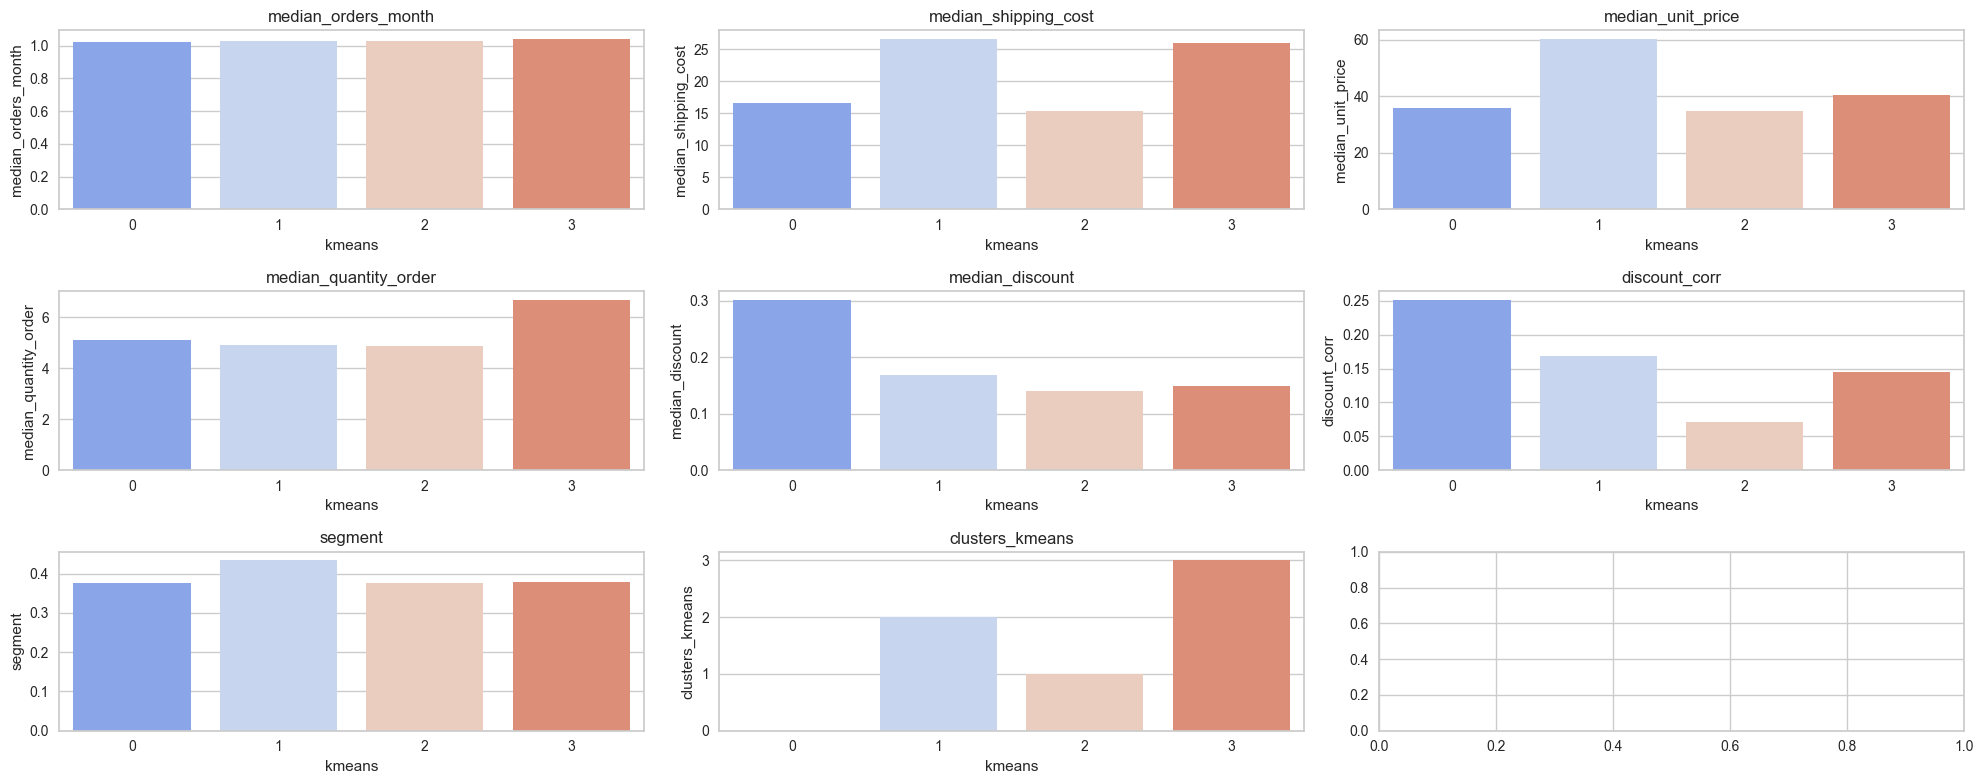

clusters_kmeans
2    307
0    174
1    153
3    121
Name: count, dtype: int64

: 

In [ ]:
warnings.filterwarnings("ignore")
customer_aggregated_v2_outliers = customer_aggregated_v2_outliers.astype("float")
clusterizador_v2 = sc.Clustering(customer_aggregated_v2_outliers)

# 
clusterizador_v2.preparar_dataframe(scaler="robust")

customer_aggregated_v2_clustered = clusterizador_v2.modelo_kmeans(customer_aggregated_v2_outliers,4)

sns.pairplot(customer_aggregated_v2_clustered, hue="clusters_kmeans")

clusterizador_v2.plot_clusters("kmeans")
warnings.filterwarnings("default")

customer_aggregated_v2_clustered["clusters_kmeans"].value_counts()